In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib 
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [2]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict






In [3]:

animals = ['PV_62','PV_126','PV_57']
block_lists = [[23,24,26,38],[7,8,9,10,11,12],[7,8,9,11,12,13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experi

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax 
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for block 026...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [5]:
# from here is degree conversion:

In [6]:

# read Tali's file:
    

def append_angle_data(eye_df, new_df):
    """
    Appends the kinematics columns (phi and theta) from new_df to eye_df.
    The function renames 'phi' to 'k_phi' and 'theta' to 'k_theta', then merges
    on the shared 'OE_timestamp' column.
    
    Parameters:
    - eye_df: pandas DataFrame containing the eye tracking data.
    - new_df: pandas DataFrame containing the new kinematics data with columns
              'phi' and 'theta' along with 'OE_timestamp' (and possibly others).
    
    Returns:
    - merged_df: pandas DataFrame resulting from merging the new kinematics data
                 into eye_df.
    """
    # Select the necessary columns and rename them
    angle_data = new_df[['OE_timestamp', 'phi', 'theta']].rename(
        columns={'phi': 'k_phi', 'theta': 'k_theta'}
    )
    
    # Merge on OE_timestamp using a left join to preserve all rows in eye_df
    merged_df = pd.merge(eye_df, angle_data, on='OE_timestamp', how='left')
    
    return merged_df
for block in block_collection:
    print(block)
    try:
        left_angles = pd.read_csv([i for i in block.analysis_path.iterdir() if ('left_kerr_angles_current.csv' in str(i)) ][0])
        right_angles = pd.read_csv([i for i in block.analysis_path.iterdir() if ('right_kerr_angles_current.csv' in str(i)) ][0])
    except IndexError:
        print(f'{block} has a problem')
    block.left_eye_data = append_angle_data(block.left_eye_data,left_angles)
    block.right_eye_data = append_angle_data(block.right_eye_data,right_angles)

    

PV_62, block 023, on 2023-04-27_10-52-42
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35
PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39
PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


In [ ]:
# #  flip phi/theta - only uncomment when you need it!
# Use a temporary name to avoid collision
for block in block_collection:
    block.left_eye_data = block.left_eye_data.rename(columns={'k_phi': 'temp'})
    block.left_eye_data = block.left_eye_data.rename(columns={'k_theta': 'k_phi'})
    block.left_eye_data = block.left_eye_data.rename(columns={'temp': 'k_theta'})
    
    block.right_eye_data = block.right_eye_data.rename(columns={'k_phi': 'temp'})
    block.right_eye_data = block.right_eye_data.rename(columns={'k_theta': 'k_phi'})
    block.right_eye_data = block.right_eye_data.rename(columns={'temp': 'k_theta'})


In [21]:
block

BlockSync object for animal PV_126 with 
block_num 012 at date PV126_Trial116_eyeTracking_h8

In [7]:
from bokeh.plotting import figure, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource

def plot_eye_comparison_over_time(eye_df):
    """
    Creates two interactive Bokeh line plots arranged vertically to compare 
    the twin datasets over time.
    
    The first plot displays:
      - center_x (pixel-based) and 
      - k_phi (angular, in degrees)
    against ms_axis (time in milliseconds).
    
    The second plot displays:
      - center_y (pixel-based) and 
      - k_theta (angular, in degrees)
    against ms_axis.
    
    Both plots include interactive tools (pan, zoom, box zoom, reset, save) and 
    allow you to zoom and pan through time.
    
    Parameters:
      eye_df : pandas.DataFrame
          DataFrame with columns:
            - 'ms_axis': Time in milliseconds.
            - 'center_x': Pixel-based x-coordinate.
            - 'center_y': Pixel-based y-coordinate.
            - 'k_phi': Angular phi (in degrees), analogous to center_x.
            - 'k_theta': Angular theta (in degrees), analogous to center_y.
    """
    
    # Create a ColumnDataSource for efficient plotting
    source = ColumnDataSource(eye_df)
    tools = "pan,wheel_zoom,box_zoom,reset,save"
    
    # Plot 1: ms_axis vs. center_x and k_phi
    p1 = figure(title="Time Series: center_x vs. k_phi", 
                x_axis_label="Time (ms)", 
                y_axis_label="center_x / k_phi",
                tools=tools, width=1500, height=1300)
    p1.line(x='ms_axis', y='center_x', source=source, color="blue", legend_label="center_x", line_width=2)
    p1.line(x='ms_axis', y='k_phi', source=source, color="red", legend_label="k_phi", line_width=2)
    p1.legend.location = "top_left"
    
    # Plot 2: ms_axis vs. center_y and k_theta
    p2 = figure(title="Time Series: center_y vs. k_theta", 
                x_axis_label="Time (ms)", 
                y_axis_label="center_y / k_theta",
                tools=tools, width=1500, height=1300)
    p2.line(x='ms_axis', y='center_y', source=source, color="blue", legend_label="center_y", line_width=2)
    p2.line(x='ms_axis', y='k_theta', source=source, color="red", legend_label="k_theta", line_width=2)
    p2.legend.location = "top_left"
    
    # Layout the plots in a vertical column and display them
    layout = column(p1, p2)
    show(layout)


plot_eye_comparison_over_time(block.left_eye_data)

In [8]:
# Now make a function to update saccade detection:
import numpy as np
import pandas as pd

def create_saccade_events_with_direction_segmentation_updated(
    eye_data_df,
    speed_threshold,  # angular speed threshold in degrees/frame
    directional_delta_threshold_deg=15,  # threshold for change in instantaneous angle (degrees)
    magnitude_calib=1,
    speed_profile=True,
    min_subsaccade_samples=2
):
    """
    Detects saccade events using an angular speed threshold (degrees/frame) and
    segments them based on directional shifts computed from the angular (k_phi/k_theta)
    data. This function computes both pixel-based metrics (from center_x/center_y) and
    angular-based metrics (from k_phi/k_theta) for comparison.
    
    Parameters:
      - eye_data_df (pd.DataFrame): Input DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 
            and 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (in degrees/frame) for saccade detection.
      - directional_delta_threshold_deg (float): Threshold (in degrees) for the instantaneous angle change
            that defines a segmentation boundary within a saccade.
      - magnitude_calib (float): Calibration factor to convert pixel-based speeds to millimeters.
            Not applied to the angular data.
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid subsaccade.
      
    Returns:
      - df (pd.DataFrame): The input DataFrame with additional computed columns.
      - saccade_events_df (pd.DataFrame): A DataFrame listing detected and segmented saccade events,
            with both pixel-derived and angular-derived metrics.
    """
    # Make a copy to avoid modifying the original DataFrame
    df = eye_data_df.copy()
    
    ### 1. Compute Frame-to-Frame Differences
    # -- Pixel-based differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"]**2 + df["speed_y"]**2)
    
    # -- Angular-based differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"]**2 + df["angular_speed_theta"]**2)
    
    ### 2. Saccade Detection Based on Angular Speed
    # Flag candidate saccade samples using the angular speed threshold (degrees/frame)
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold
    
    # Determine saccade onsets and offsets (using angular speed based flag)
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1  # include one frame before threshold crossing
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    
    # Handle possible mismatches in start/end indices
    if len(saccade_on_inds) > len(saccade_off_inds):
        if len(saccade_on_inds) - len(saccade_off_inds) == 1:
            print("Detected unmatched final saccade start index. Truncating last saccade start index.")
            saccade_on_inds = saccade_on_inds[:-1]
        else:
            raise ValueError("Mismatch between saccade start and end indices. Manual inspection required.")
    
    saccade_events = []
    
    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind+1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue
        
        # Compute instantaneous angles for each frame in the saccade.
        # -- Pixel-based instantaneous angle (derived from center_x/center_y differences)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        # -- Angular-based instantaneous angle (derived from k_phi/k_theta differences)
        saccade_df["inst_angle_deg"] = np.degrees(np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))
        
        # Define an inline helper to compute minimal angular difference (in degrees)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
        
        # Compute differences between consecutive instantaneous angular-based angles (handling circularity)
        angles = saccade_df["inst_angle_deg"].values
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i+1], angles[i]) for i in range(len(angles)-1)])
        
        # Identify candidate segmentation boundaries where the absolute difference exceeds the threshold
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()
        
        # Always include the first and last sample as boundaries
        if not candidate_boundaries:
            boundaries = [0, len(saccade_df) - 1]
        else:
            boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]
        
        # Segment the saccade. Overlap boundaries so that the end of one segment is the start of the next.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i+1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue
            
            # Timing and sample indices for this subsaccade
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]
            
            # Pixel-based magnitude (sum of speeds) with calibration
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib
            
            # Angular-based magnitude (in degrees, no calibration applied)
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()
            
            # Compute overall saccade angle for the segment:
            # -- Pixel-based overall angle (using center_x and center_y differences)
            initial_pos_pixel = subsaccade.iloc[0][["center_x", "center_y"]]
            final_pos_pixel = subsaccade.iloc[-1][["center_x", "center_y"]]
            overall_angle_pixel = (np.degrees(np.arctan2(
                final_pos_pixel["center_y"] - initial_pos_pixel["center_y"],
                final_pos_pixel["center_x"] - initial_pos_pixel["center_x"]
            )) % 360)
            
            # -- Angular-based overall angle (using k_phi and k_theta differences)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)
            
            # Speed profiles for the segment
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values
            
            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "overall_angle_pixel": overall_angle_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle['k_theta'],
                "theta_end_pos": final_pos_angle['k_theta'],
                "phi_init_pos": initial_pos_angle['k_phi'],
                "phi_end_pos": final_pos_angle['k_phi']
            })
    
    # Convert the list of saccade events into a DataFrame
    saccade_events_df = pd.DataFrame(saccade_events)
    
    # Optionally remove intermediate columns
    df.drop(["is_saccade_angle"], axis=1, inplace=True)
    # calculate delta theta and delta phi
    saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
    saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']
    return df, saccade_events_df



In [9]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_updated(block.left_eye_data,
                                                                                                        4,  # angular speed threshold in degrees/frame
                                                                                                        directional_delta_threshold_deg=35,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=block.R_pix_size,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_updated(block.right_eye_data,
                                                                                                        4,  # angular speed threshold in degrees/frame
                                                                                                        directional_delta_threshold_deg=35,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=block.L_pix_size,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)


PV_62, block 023, on 2023-04-27_10-52-42
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31
PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18
PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35
PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
Detected unmatched final saccade start index. Truncating last saccade start index.
PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39
PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


In [24]:
import numpy as np
import pandas as pd

def create_saccade_events_with_direction_segmentation_robust(
    eye_data_df,
    speed_threshold,                # angular speed threshold in degrees/frame
    directional_delta_threshold_deg=15,  # threshold for change in instantaneous angle (degrees)
    magnitude_calib=1,
    speed_profile=True,
    min_subsaccade_samples=2,
    min_net_disp=0.5                # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta) 
         is below a user-specified minimal value.
    
    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.
    
    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()
    
    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"]**2 + df["speed_y"]**2)
    
    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"]**2 + df["angular_speed_theta"]**2)
    
    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold
    
    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    
    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]
    
    saccade_events = []
    
    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind+1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue
        
        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))
        
        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180
        
        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i+1], angles[i]) for i in range(len(angles)-1)])
        
        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()
        
        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]
        
        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i+1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue
            
            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"])**2 + 
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"])**2)
            
            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue
            
            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]
            
            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib
            
            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()
            
            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)
            
            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values
            
            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })
    
    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)
    
    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)
    
    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']
    
    return df, saccade_events_df


In [25]:

 l_saccade_df_new = create_saccade_events_with_direction_segmentation_robust(block.left_eye_data,
                                                                                                    4,  # angular speed threshold in degrees/frame
                                                                                                    directional_delta_threshold_deg=35,  # threshold for change in instantaneous angle (degrees)
                                                                                                    magnitude_calib=block.R_pix_size,
                                                                                                    speed_profile=True,
                                                                                                    min_subsaccade_samples=2)
r_saccade_df_new = create_saccade_events_with_direction_segmentation_updated(block.right_eye_data,
                                                                                                    4,  # angular speed threshold in degrees/frame
                                                                                                    directional_delta_threshold_deg=35,  # threshold for change in instantaneous angle (degrees)
                                                                                                    magnitude_calib=block.L_pix_size,
                                                                                                    speed_profile=True,
                                                                                                    min_subsaccade_samples=2)


In [9]:
import numpy as np
import pandas as pd

def filter_saccade_events(saccade_events_df, min_length=1, min_disp_threshold=0.1):
    """
    Filters saccade events based on the number of frames (length) and overall angular displacement.
    
    Parameters:
      - saccade_events_df: DataFrame produced by create_saccade_events_with_direction_segmentation_updated.
        It should include at least the following columns:
          'length', 'theta_init_pos', 'theta_end_pos', 'phi_init_pos', 'phi_end_pos',
          or alternatively 'delta_theta' and 'delta_phi'.
      - min_length: Minimum number of frames for a saccade event (default is 1).
      - min_disp_threshold: Minimum overall angular displacement (in degrees) required for an event.
    
    Returns:
      - filtered_df: A DataFrame containing only saccade events with length >= min_length
                     and overall displacement >= min_disp_threshold.
    """
    # Make a copy to avoid modifying the original dataframe.
    filtered_df = saccade_events_df.copy()
    
    # Ensure that we have the delta columns.
    if 'delta_theta' not in filtered_df.columns or 'delta_phi' not in filtered_df.columns:
        # Compute delta_theta and delta_phi from the initial and final positions.
        filtered_df['delta_theta'] = filtered_df['theta_end_pos'] - filtered_df['theta_init_pos']
        filtered_df['delta_phi'] = filtered_df['phi_end_pos'] - filtered_df['phi_init_pos']
    
    # Compute the overall angular displacement.
    filtered_df['overall_disp'] = np.sqrt(filtered_df['delta_theta']**2 + filtered_df['delta_phi']**2)
    
    # Filter out events with length below min_length and overall displacement below threshold.
    filtered_df = filtered_df[(filtered_df['length'] >= min_length) & 
                              (filtered_df['overall_disp'] >= min_disp_threshold)]
    
    return filtered_df


for block in block_collection:
    print(f'{block} before = {len(block.l_saccade_df)+len(block.r_saccade_df)}')
    block.l_saccade_df = filter_saccade_events(block.l_saccade_df,min_length=1,min_disp_threshold=0.23)
    block.r_saccade_df = filter_saccade_events(block.r_saccade_df,min_length=1,min_disp_threshold=0.23)
    print(f'{block} after = {len(block.l_saccade_df)+len(block.r_saccade_df)}')

PV_62, block 023, on 2023-04-27_10-52-42 before = 734
PV_62, block 023, on 2023-04-27_10-52-42 after = 617
PV_62, block 024, on 2023-04-27_11-22-56 before = 489
PV_62, block 024, on 2023-04-27_11-22-56 after = 407
PV_62, block 026, on 2023-04-27_12-21-41 before = 657
PV_62, block 026, on 2023-04-27_12-21-41 after = 565
PV_62, block 038, on 2023-05-01_13-57-45 before = 735
PV_62, block 038, on 2023-05-01_13-57-45 after = 621
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 before = 2480
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 after = 2296
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41 before = 483
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41 after = 434
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15 before = 296
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15 after = 245
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57 before = 350
PV_126, block 010, on PV126_Trial19_wake6_2024-0

PV_62, block 023, on 2023-04-27_10-52-42 before = 1322
PV_62, block 023, on 2023-04-27_10-52-42 after = 1044
PV_62, block 024, on 2023-04-27_11-22-56 before = 1322
PV_62, block 024, on 2023-04-27_11-22-56 after = 1044
PV_62, block 026, on 2023-04-27_12-21-41 before = 1338
PV_62, block 026, on 2023-04-27_12-21-41 after = 1066
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 before = 2672
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 after = 2353
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41 before = 524
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41 after = 451
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15 before = 802
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15 after = 687
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57 before = 564
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57 after = 492
PV_126, block 011, on PV126_Trial115_eyeTracking_w7 before = 3197
PV_126, block 011, on PV126_Trial115_eyeTracking_w7 after = 2827
PV_126, block 012, on PV126_Trial116_eyeTracking_h8 before = 208
PV_126, block 012, on PV126_Trial116_eyeTracking_h8 after = 174


In [8]:
import os
import pickle
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_saccade_magnitude_vs_velocity_time_to_peak_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3, 
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade magnitudes versus angular peak velocities as a compact scatter plot.
    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular'
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
      - Time-to-peak is assumed to be stored in 'time_to_peak_v'
    
    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades containing angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, but kept for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, convert angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """
    
    def extract_saccade_metrics_time_to_peak_angular(saccade_collection, eye_label):
        """
        Extracts angular saccade metrics for the given eye.
        Assumes that saccade_collection contains:
          - 'magnitude_raw_angular': angular amplitude (deg)
          - 'speed_profile_angular': list/array of angular speeds (deg/frame)
          - 'time_to_peak_v': time to reach peak angular speed (ms)
        """
        filtered_data = saccade_collection.query('eye == @eye_label')
        magnitudes = filtered_data['magnitude_raw_angular'].values
        # Compute peak angular speed (in deg/frame) from the angular speed profile
        peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
        time_to_peak = filtered_data['time_to_peak_v'].values
        return magnitudes, peak_velocities, time_to_peak

    # Get metrics for left and right eyes
    l_magnitudes, l_peak_velocities, l_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'R')
    
    # Concatenate the data from both eyes
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_time_to_peaks = np.concatenate((l_time_to_peak, r_time_to_peak))
    
    # Convert from deg/frame to deg/ms if requested
    frame_duration = 1000 / frame_rate_fps  # ms per frame
    if velocity_to_deg_per_ms:
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame
    data = pd.DataFrame({
        'magnitude': all_magnitudes,           # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities,   # Angular peak velocity in deg/ms
        'time_to_peak': all_time_to_peaks         # Time to peak (ms)
    })
    
    # Remove outliers (this function should be defined elsewhere)
    cleaned_data = remove_outliers_from_df(data, threshold)
    
    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_time_to_peaks = cleaned_data['time_to_peak'].values
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_time_to_peaks, cmap='viridis', alpha=0.7)
    
    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)
    
    # Add a limiting slope line (here, a line with slope = 1/frame_duration as a reference)
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    ax.legend(fontsize=8)
    
    # Add colorbar for time-to-peak
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Time-To-Peak [ms]', fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    
    # Export plot and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_time_to_peak_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_time_to_peak_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_time_to_peak_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()


In [10]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 023, on 2023-04-27_10-52-42
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 024, on 2023-04-27_11-22-56
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\oe_files\2023-04-27_12-21-41\Record Node 108\analysis\recNames=Block0026,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 026, on 2023-04-27_12-21-41
path to mat file is Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\oe_files\2023-05-01_13-57-45\Record Node 108\analysis\recNames=Block0038,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 038, on 2023-05-01_13-57-45
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\P

In [11]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [12]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [13]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


114it [00:00, 4749.73it/s]
257it [00:00, 6267.84it/s]
242it [00:00, 5499.86it/s]

495 566
112 194
260 379



322it [00:00, 7666.74it/s]
535it [00:00, 5297.18it/s]

311 364


1170it [00:00, 5318.14it/s]
205it [00:00, 3534.51it/s]
115it [00:00, 6388.17it/s]

609 1207
182 250
127 154



123it [00:00, 5347.44it/s]
734it [00:00, 5169.02it/s]

139 200



61it [00:00, 5082.09it/s]
474it [00:00, 5924.90it/s]

519 895
40 61
1535 1699



401it [00:00, 5728.48it/s]
460it [00:00, 6216.37it/s]


541 720
547 696


1066it [00:00, 5052.12it/s]
630it [00:00, 3818.17it/s]

732 1226



503it [00:00, 5028.12it/s]

258 512


870it [00:00, 5208.43it/s]


1219 1676


In [14]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [15]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [37]:
def remove_overlapping_saccades(df, start_col='saccade_start_timestamp', end_col='saccade_end_timestamp', eye_col='eye'):
    """
    Removes duplicate/overlapping saccade events from the dataframe.
    
    For each eye (grouped by the 'eye' column), the function assumes that
    the events are sorted by their start timestamps. It then checks sequentially
    and keeps an event only if its start timestamp is greater than or equal to
    the end timestamp of the previously kept event.
    
    Parameters:
        df (pd.DataFrame): DataFrame with saccade events.
        start_col (str): Column name for the saccade start timestamp.
        end_col (str): Column name for the saccade end timestamp.
        eye_col (str): Column name indicating the eye ('L' or 'R').
        
    Returns:
        pd.DataFrame: A filtered DataFrame with overlapping saccades removed.
    """
    filtered_dfs = []
    for eye in df[eye_col].unique():
        # Get events for this eye and sort them by the start timestamp.
        sub_df = df[df[eye_col] == eye].sort_values(by=start_col).copy()
        non_overlap_rows = []
        last_end = None

        for idx, row in sub_df.iterrows():
            current_start = row[start_col]
            current_end = row[end_col]
            
            # If no previous event or the current event starts after (or exactly at) the end
            # of the previous event, keep it.
            if last_end is None or current_start >= last_end:
                non_overlap_rows.append(row)
                last_end = current_end
            else:
                # An overlap is detected; report it (optional) and skip this event.
                print(f"Overlap detected for eye {eye} at index {idx}: current start {current_start} < previous end {last_end}. Skipping duplicate.")
        
        filtered_dfs.append(pd.DataFrame(non_overlap_rows))
    
    # Concatenate the cleaned events for all eyes and sort by eye and start time.
    cleaned_df = pd.concat(filtered_dfs).sort_values(by=[eye_col, start_col]).reset_index(drop=True)
    return cleaned_df
all_saccade_collection = remove_overlapping_saccades(all_saccade_collection, start_col='saccade_start_timestamp', end_col='saccade_end_timestamp', eye_col='eye')
synced_saccade_collection = remove_overlapping_saccades(synced_saccade_collection, start_col='saccade_start_timestamp', end_col='saccade_end_timestamp', eye_col='eye')
non_synced_saccade_collection = remove_overlapping_saccades(non_synced_saccade_collection, start_col='saccade_start_timestamp', end_col='saccade_end_timestamp', eye_col='eye')

Overlap detected for eye L at index 0: current start 737587.0 < previous end 738606.0. Skipping duplicate.
Overlap detected for eye L at index 358: current start 738533.0 < previous end 738606.0. Skipping duplicate.
Overlap detected for eye L at index 165: current start 792288.0 < previous end 792967.0. Skipping duplicate.
Overlap detected for eye L at index 5152: current start 1945153.0 < previous end 1945667.0. Skipping duplicate.
Overlap detected for eye L at index 7102: current start 1946397.0 < previous end 1946507.0. Skipping duplicate.
Overlap detected for eye L at index 7103: current start 1946735.0 < previous end 1946846.0. Skipping duplicate.
Overlap detected for eye L at index 5159: current start 1954629.0 < previous end 1955534.0. Skipping duplicate.
Overlap detected for eye L at index 5160: current start 1954968.0 < previous end 1955534.0. Skipping duplicate.
Overlap detected for eye L at index 2: current start 2031402.0 < previous end 2032081.0. Skipping duplicate.
Overla

In [35]:
print(len(cleaned_saccade_df))
print(len(all_saccade_collection))

15682
15682


In [36]:
def add_time_to_peak_velocity(df, sampling_interval_ms):
    """
    Adds a 'time_to_peak_v' column to the dataframe, representing the time (in ms) 
    to reach the peak velocity in the 'speed_profile' column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'speed_profile' column with lists of velocities.
    - sampling_interval_ms (float): Sampling interval in milliseconds.

    Returns:
    - pd.DataFrame: Modified DataFrame with a new 'time_to_peak_v' column.
    """
    def compute_time_to_peak(speed_profile):
        if speed_profile is None or len(speed_profile) == 0:  # Explicit check for empty or None
            return np.nan
        peak_index = np.argmax(speed_profile)  # Index of maximum speed
        return peak_index * sampling_interval_ms

    # Apply the computation to each row
    df['time_to_peak_v'] = df['speed_profile_angular'].apply(compute_time_to_peak)
    return df

all_saccade_collection = add_time_to_peak_velocity(all_saccade_collection,17)
synced_saccade_collection = add_time_to_peak_velocity(synced_saccade_collection,17)
non_synced_saccade_collection = add_time_to_peak_velocity(non_synced_saccade_collection,17)
saccade_collection = add_time_to_peak_velocity(saccade_collection,17)

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.stats import t
import datetime
import os
import pickle

def remove_outliers_from_df(df, threshold=3):
    mask = (np.abs(df - df.mean()) <= threshold * df.std()).all(axis=1)
    return df[mask]

def extract_saccade_metrics_length_angular(saccade_collection, eye_label):
    """
    Extracts angular saccade metrics for the given eye.
    Uses the angular amplitude (in degrees) from 'magnitude_raw_angular'
    and angular speed profiles from 'speed_profile_angular'. The saccade length is
    defined as the number of samples in the angular speed profile.
    """
    filtered_data = saccade_collection.query('eye == @eye_label')
    magnitudes = filtered_data['magnitude_raw_angular'].values
    peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
    saccade_length = np.array([len(profile) for profile in filtered_data['speed_profile_angular']])
    return magnitudes, peak_velocities, saccade_length

def plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3, 
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade amplitudes versus angular peak velocities as a scatter plot.
    
    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular' (in degrees).
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
        (in deg/frame) and then converted to deg/ms (if velocity_to_deg_per_ms is True).
      - Saccade length is defined as the number of frames in the angular speed profile, which is then
        converted to milliseconds (by multiplying by 17).
    
    Scatter points are colored by the saccade length (in ms). A regression line is fitted for each
    group (grouped by saccade length), and a reference line is plotted.
    
    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades with angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, converts angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """
    # Extract metrics for left and right eyes using angular columns
    l_magnitudes, l_peak_velocities, l_length = extract_saccade_metrics_length_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_length = extract_saccade_metrics_length_angular(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_lens = np.concatenate((l_length, r_length))
    
    # Convert saccade length from frames to milliseconds (using factor ~17 ms per frame)
    all_lens = all_lens * 17

    # Convert angular peak velocity from deg/frame to deg/ms if requested.
    # Each frame lasts frame_duration ms = 1000 / frame_rate_fps.
    if velocity_to_deg_per_ms:
        frame_duration = 1000 / frame_rate_fps  # ms per frame (e.g., ~16.67 ms for 60 fps)
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,         # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities, # Angular peak velocity in deg/ms
        'length': all_lens                    # Saccade duration in milliseconds
    })

    cleaned_data = remove_outliers_from_df(data, threshold)
    print(f'saccades in plot: {len(cleaned_data)}')

    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_len = cleaned_data['length'].values

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot with points colored by saccade length (in ms)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_len, cmap='viridis', alpha=0.7)

    # Customize appearance
    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Add horizontal line if velocity_threshold is provided
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Group data by saccade length (in ms) and fit regression lines
    grouped_data = cleaned_data.groupby('length')
    norm = Normalize(vmin=cleaned_data['length'].min(), vmax=cleaned_data['length'].max())
    cmap_ = plt.cm.viridis

    for length, group in grouped_data:
        clean_group = group[['magnitude', 'peak_velocity']].dropna()
        x = clean_group['magnitude'].values.reshape(-1, 1)
        y = clean_group['peak_velocity'].values

        line_color = cmap_(norm(length))
        if len(x) > 1:
            model = LinearRegression().fit(x, y)
            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(x, y)
            y_pred = model.predict(x)
            residuals = y - y_pred
            rse = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
            se_slope = rse / np.sqrt(np.sum((x - x.mean())**2))
            t_stat = slope / se_slope
            df_deg = len(x) - 2
            p_value = 2 * t.sf(np.abs(t_stat), df_deg)
            x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            y_vals = model.predict(x_vals)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=1, color='black', alpha=0.9, zorder=1)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=0.5, color=line_color, alpha=0.7, zorder=2)
            legend_text = f'Len={length} ms, R²={r_squared:.2f}, p={p_value:.2g}'
            print(legend_text, '\n')

    # Add a reference line with slope = 1/frame_duration in deg/ms.
    # For example, if amplitude = 1 deg, then minimum detectable speed = 1/frame_duration deg/ms.
    frame_duration = 1000 / frame_rate_fps
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    #ax.legend(fontsize=8)

    # Add colorbar for saccade length (in ms)
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Length [ms]', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Handle export if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_length_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


saccades in plot: 6697
Len=34 ms, R²=0.84, p=0 

Len=51 ms, R²=0.83, p=0 

Len=68 ms, R²=0.81, p=0 

Len=85 ms, R²=0.76, p=9.2e-127 

Len=102 ms, R²=0.80, p=1.3e-43 


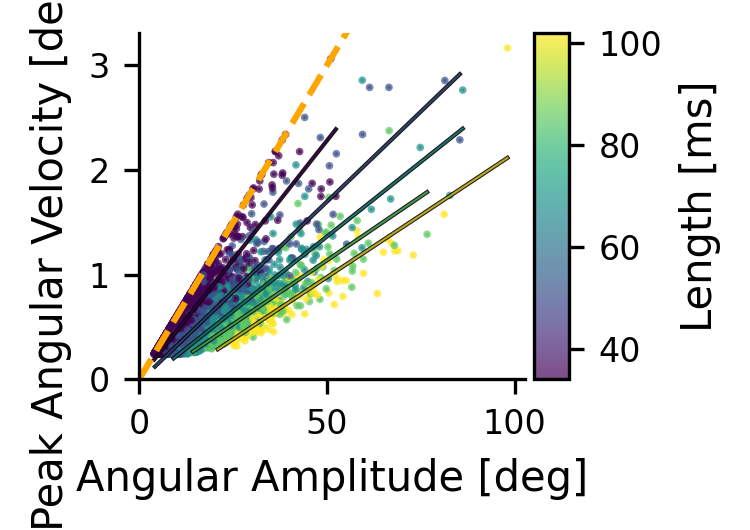

In [38]:
plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection.query('length < 6'), non_synced_saccade_collection.query('length < 6'), export_path=None, threshold=15, 
    fig_size=(2, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

saccades in plot: 3045
Len=34 ms, R²=0.77, p=0 

Len=51 ms, R²=0.70, p=2.1e-265 

Len=68 ms, R²=0.69, p=4.6e-138 

Len=85 ms, R²=0.67, p=1.5e-28 


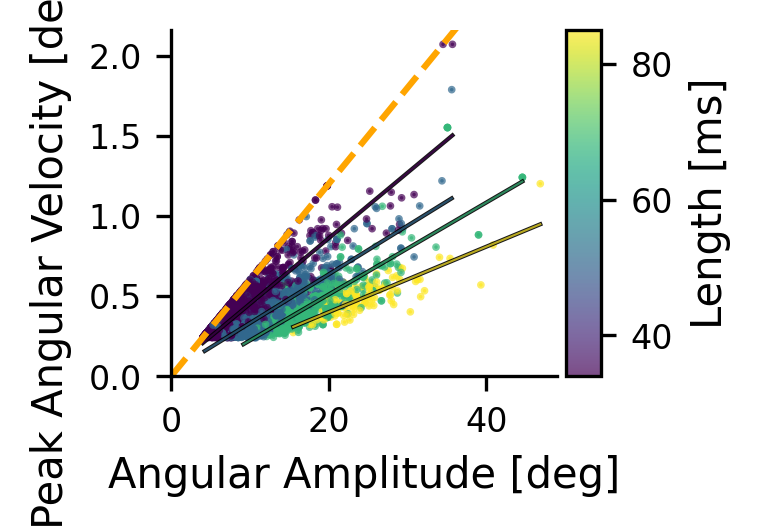

In [25]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'

plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection.query('animal=="PV_126" and length < 5'), non_synced_saccade_collection.query('animal=="PV_126" and length < 5'), export_path=None, threshold=15, 
    fig_size=(2, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

saccades in plot: 3424
Len=34 ms, R²=0.85, p=0 

Len=51 ms, R²=0.86, p=0 

Len=68 ms, R²=0.82, p=4.9e-262 

Len=85 ms, R²=0.74, p=6.3e-78 


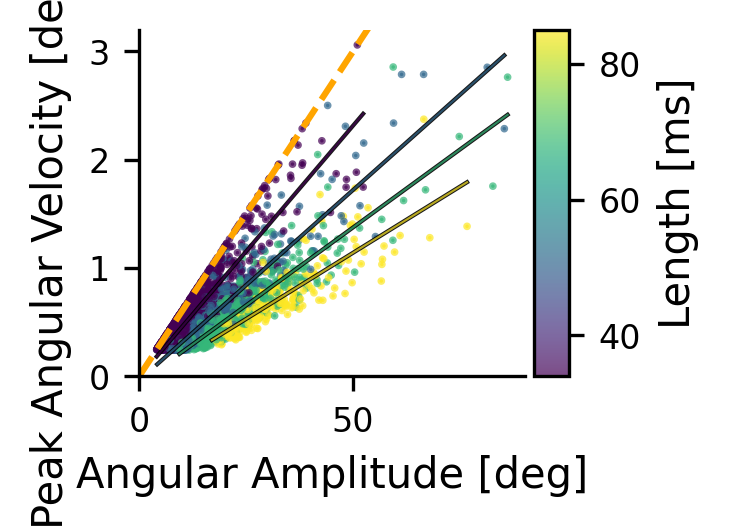

In [39]:
plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection.query('animal=="PV_57"  and length < 5'), non_synced_saccade_collection.query('animal=="PV_57"  and length < 6'), export_path=None, threshold=30, 
    fig_size=(2, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

Value = 17, count = 2408
Value = 34, count = 556
Value = 51, count = 25
Value = 68, count = 4


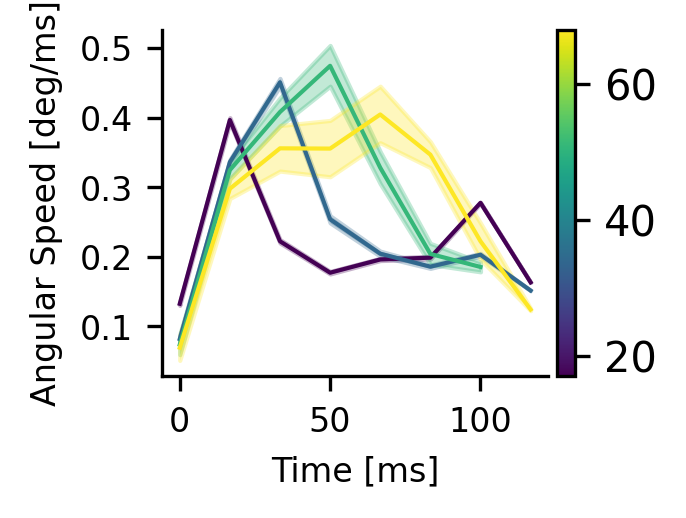

In [40]:
import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde, t
from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

def plot_speed_profiles_with_export_angular(
    saccade_collection, sampling_rate=60, floor=None, ceiling=None, export_path=None, 
    fig_size=(2.5,1.7), set_xlim=None
):
    """
    Plots average angular speed profiles grouped by unique time-to-peak values, up to a ceiling value.
    Angular speed profiles are taken from the 'speed_profile_angular' column, which is assumed to be in deg/frame.
    They are converted to deg/ms by dividing by the frame duration (1000/sampling_rate).
    
    Parameters:
      - saccade_collection: DataFrame containing angular speed profiles (in 'speed_profile_angular') and 
                            time-to-peak values in 'time_to_peak_v'.
      - sampling_rate: Sampling rate in Hz (default 60 Hz).
      - floor: Minimum time-to-peak value to include (optional).
      - ceiling: Maximum time-to-peak value to include (optional).
      - export_path: Directory path to export the plot and data (optional).
      - fig_size: Figure size (width, height).
      - set_xlim: Optional x-axis limits.
    """
    # Filter unique time-to-peak values and apply ceiling/floor if provided
    unique_time_to_peak_values = np.unique(saccade_collection['time_to_peak_v'].dropna().astype(int))
    if ceiling is not None:
        unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values <= ceiling]
    if floor is not None:
        unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values >= floor]
    unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values >= 0]
    
    # Prepare the figure
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=unique_time_to_peak_values.min(), vmax=unique_time_to_peak_values.max())
    
    # Calculate frame duration (ms per frame)
    frame_duration = 1000 / sampling_rate  # e.g., ~16.67 ms at 60 Hz

    # Iterate over each unique time-to-peak value
    for idx, time_to_peak in enumerate(unique_time_to_peak_values):
        # Filter the angular speed profiles for the current time-to-peak value.
        # Note: We now use the 'speed_profile_angular' column.
        profiles = saccade_collection.loc[
            saccade_collection['time_to_peak_v'] == time_to_peak,
            'speed_profile_angular'
        ].dropna().values
        
        if len(profiles) == 0:
            continue

        # Convert each speed profile from deg/frame to deg/ms
        converted_profiles = []
        for profile in profiles:
            # Ensure profile is a NumPy array
            profile = np.array(profile)
            # Convert: deg/frame divided by (ms/frame) gives deg/ms.
            converted_profiles.append(profile / frame_duration)
        
        # Align the converted profiles to the same length
        max_length = max(len(p) for p in converted_profiles)
        aligned_profiles = np.full((len(converted_profiles), max_length), np.nan)
        for i, profile in enumerate(converted_profiles):
            aligned_profiles[i, :len(profile)] = profile

        # Compute average profile and standard error
        avg_profile = np.nanmean(aligned_profiles, axis=0)
        std_error = np.nanstd(aligned_profiles, axis=0) / np.sqrt(len(converted_profiles))

        # Define time points (in ms) for the profile based on sampling rate
        time_points = np.arange(0, len(avg_profile) * frame_duration, frame_duration)

        # Plot the average speed profile with its error region
        ax.plot(time_points, avg_profile, color=cmap(norm(time_to_peak)), lw=1)
        ax.fill_between(time_points, avg_profile - std_error, avg_profile + std_error,
                        color=cmap(norm(time_to_peak)), alpha=0.3)
    
    if set_xlim is not None:
        ax.set_xlim(set_xlim)
    
    # Customize the plot labels and appearance
    ax.set_xlabel('Time [ms]', fontsize=8)
    ax.set_ylabel('Angular Speed [deg/ms]', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add a colorbar for time-to-peak values
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    # Uncomment the following line if you wish to add a label to the colorbar:
    # cbar.set_label('Time-to-Peak [ms]', fontsize=8)
    
    # Print counts for debugging
    for value in unique_time_to_peak_values:
        count = len(saccade_collection.query('time_to_peak_v == @value'))
        print(f'Value = {value}, count = {count}')
    
    # Export the figure and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"angular_speed_profiles_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "angular_speed_profiles.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles_segmented'
plot_speed_profiles_with_export_angular(all_saccade_collection.query('animal == "PV_126"'), sampling_rate=60, floor=1, ceiling=18*4, export_path=None, fig_size=(2,1.5), set_xlim=None)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
import datetime
import pickle

def plot_saccade_heatmaps_comparison_angle(synced_saccades, non_synced_saccades, export_path=None, nbins=200,
                                           global_min=-1.5, global_max=1.5, cmap=plt.cm.turbo, figsize=(4, 2.5)):
    """
    Plots a stacked 2D KDE heatmap for synced (top) and non-synced saccades using angle data.
    Instead of the calibrated pupil displacements (calib_dx, calib_dy), it uses the angle columns:
      - k_phi (horizontal angle in degrees)
      - k_theta (vertical angle in degrees)
    
    The heatmaps are normalized (integral = 1) and a consistent colorbar scale is used across both conditions.
    
    Parameters:
      - synced_saccades: DataFrame with saccade data for the synced condition.
      - non_synced_saccades: DataFrame with saccade data for the non-synced condition.
      - export_path: Path to export the plot and data (optional).
      - nbins: Number of bins for KDE evaluation.
      - global_min, global_max: Axis limits for KDE evaluation.
      - cmap: Colormap for the heatmap.
      - figsize: Figure size tuple.
    """
    # Extract data using the angle columns
    def extract_eye_data(df, eye):
        # Instead of calib_dx and calib_dy, we now use k_phi and k_theta
        return df.query('eye == @eye')[['calib_dx', 'calib_dy']].dropna().values.T
    
    # For synced saccades
    l_phi_s, l_theta_s = extract_eye_data(synced_saccades, "L")
    r_phi_s, r_theta_s = extract_eye_data(synced_saccades, "R")
    # For non-synced saccades
    l_phi_ns, l_theta_ns = extract_eye_data(non_synced_saccades, "L")
    r_phi_ns, r_theta_ns = extract_eye_data(non_synced_saccades, "R")
    
    # Function to evaluate KDE with integral normalization
    def evaluate_kde(x, y):
        k = gaussian_kde(np.array([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j, global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)  # Normalize so the sum equals 1
        return zi
    
    # Compute KDEs for each eye and condition
    zi_r_s = evaluate_kde(r_phi_s, r_theta_s)
    zi_l_s = evaluate_kde(l_phi_s, l_theta_s)
    zi_r_ns = evaluate_kde(r_phi_ns, r_theta_ns)
    zi_l_ns = evaluate_kde(l_phi_ns, l_theta_ns)
    
    # Determine a consistent color scale across all heatmaps
    vmin = min(zi_r_s.min(), zi_l_s.min(), zi_r_ns.min(), zi_l_ns.min())
    vmax = max(zi_r_s.max(), zi_l_s.max(), zi_r_ns.max(), zi_l_ns.max())
    
    # Create figure with 2 rows and 2 columns of subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)
    
    # Helper function to plot an individual heatmap
    def plot_heatmap(ax, zi, title):
        im = ax.imshow(zi.T, extent=[global_min, global_max, global_min, global_max],
                       origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('k_phi [deg]', fontsize=8)
        ax.set_ylabel('k_theta [deg]', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im
    
    im1 = plot_heatmap(axes[0, 0], zi_r_s, 'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], zi_l_s, 'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], zi_l_ns, 'Left (Non-Synced)')
    
    # Add a colorbar to the right side of the figure
    cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    cb = plt.colorbar(im1, cax=cax)
    cb.set_label('Relative Density', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    
    # Handle export if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_angle_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_angle.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_collections_angle.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'synced': synced_saccades, 'non_synced': non_synced_saccades}, f)
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()

export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material')
synced_saccades = synced_saccade_collection.query('animal == "PV_62"')
non_synced_saccades = non_synced_saccade_collection.query('animal == "PV_62"')
plot_saccade_heatmaps_comparison_angle(synced_saccades, non_synced_saccades, export_path=None, nbins=200,
                                       global_min=-1.5, global_max=1.5, cmap=plt.cm.turbo, figsize=(4, 2.5))

KeyError: "None of [Index(['calib_dx', 'calib_dy'], dtype='object')] are in the [columns]"

269it [00:00, 1043.73it/s]
320it [00:00, 1038.17it/s]
1007it [00:00, 1139.14it/s]
492it [00:00, 1149.54it/s]


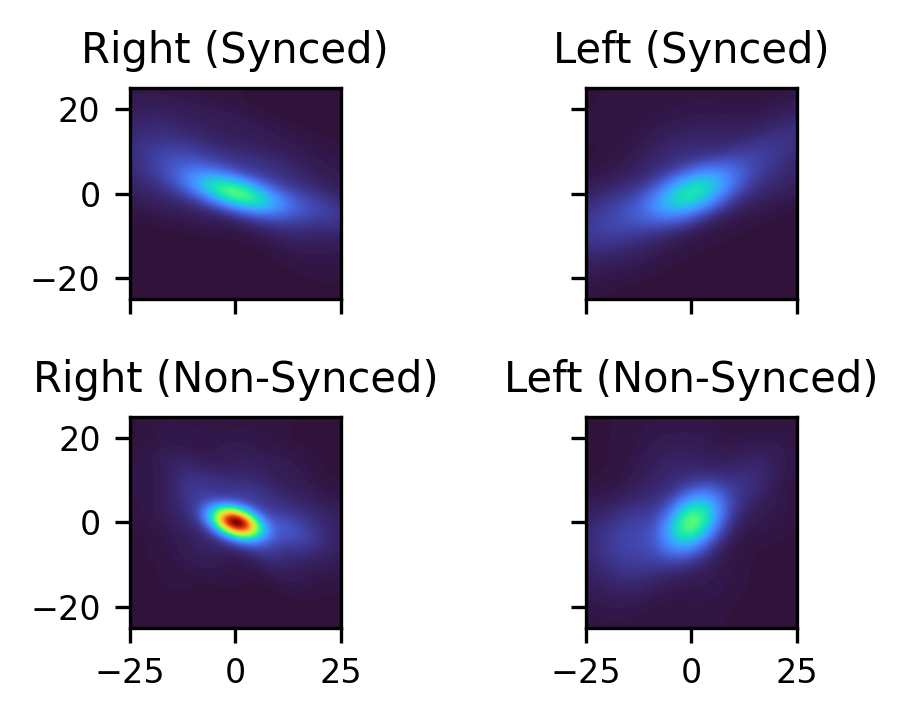

In [47]:
# this is an alternative approach for the heatmaps story: 
def plot_saccade_heatmaps_comparison_trajectories(synced_saccades, non_synced_saccades, block_dict,
                                                  export_path=None, nbins=200,
                                                  global_min=-25, global_max=25,
                                                  cmap=plt.cm.turbo, figsize=(4, 2.5)):
    """
    Plots stacked 2D KDE heatmaps for synced (top row) and non-synced (bottom row) saccade trajectories.

    For each saccade event, this function:
      - Retrieves the block object from block_dict (using block number and animal).
      - Selects the appropriate eye DataFrame (block.left_eye_data or block.right_eye_data).
      - Extracts the trajectory using the ms_axis timestamps (saccade_on_ms and saccade_off_ms).
      - Zeroes the trajectory by subtracting its initial (center_x, center_y) coordinate.
      - Aggregates all points for each condition (synced vs. non-synced) and eye (R and L).
      - Computes and plots a 2D KDE of the aggregated points.
      
    Parameters:
      - synced_saccades: DataFrame with synced saccade events. Must include columns:
          'block', 'animal', 'eye', 'saccade_on_ms', 'saccade_off_ms'.
      - non_synced_saccades: DataFrame for non-synced saccade events (same columns).
      - block_dict: Dictionary mapping block keys (e.g. "PV_126_block_7") to block objects.
      - export_path: Optional export directory.
      - nbins: Number of bins for the KDE grid.
      - global_min, global_max: Limits for the KDE evaluation grid.
      - cmap: Colormap for the heatmap.
      - figsize: Figure size.
      
    Returns:
      - None. The function displays (and optionally exports) the heatmap plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import os
    import datetime
    import pickle

    def extract_zeroed_points(saccades_df, eye):
        xs = []
        ys = []
        # Filter for the current eye (e.g., "L" or "R")
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows()):
            block_num = row['block']
            start_ms = row['saccade_on_ms']
            end_ms = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            # Choose the appropriate eye data based on row's 'eye'
            if eye == 'L':
                eye_df = block.left_eye_data
            elif eye == 'R':
                eye_df = block.right_eye_data
            else:
                continue
            # Extract the trajectory using the ms_axis time window
            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue
            # Zero the trajectory by subtracting the first coordinate
            x0 = traj['center_x'].iloc[0]
            y0 = traj['center_y'].iloc[0]
            traj_x = traj['center_x'] - x0
            traj_y = traj['center_y'] - y0
            xs.extend(traj_x.tolist())
            ys.extend(traj_y.tolist())
        return np.array(xs), np.array(ys)

    # Extract zeroed trajectory points for synced and non-synced saccades, for both eyes.
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns, r_y_ns = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns, l_y_ns = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j, global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)  # Normalize so the total density equals 1
        return xi, yi, zi

    # Compute KDEs for each set of points.
    xi_r_s, yi_r_s, zi_r_s = evaluate_kde(r_x_synced, r_y_synced)
    xi_l_s, yi_l_s, zi_l_s = evaluate_kde(l_x_synced, l_y_synced)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Determine a consistent color scale if any data exists.
    all_zi = [zi for zi in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if zi is not None]
    if all_zi:
        vmin = min(z.min() for z in all_zi)
        vmax = max(z.max() for z in all_zi)
    else:
        vmin, vmax = 0, 1

    # Create a 2x2 figure: top row for synced events; bottom row for non-synced; columns for R and L.
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300,
                             sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title):
        if zi is not None:
            im = ax.imshow(zi.T, extent=[global_min, global_max, global_min, global_max],
                           origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = None
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im

    im1 = plot_heatmap(axes[0, 0], xi_r_s, yi_r_s, zi_r_s, 'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], xi_l_s, yi_l_s, zi_l_s, 'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], xi_r_ns, yi_r_ns, zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], xi_l_ns, yi_l_ns, zi_l_ns, 'Left (Non-Synced)')

    # Add a colorbar if at least one KDE was generated.
    # if im1 is not None:
    #     cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    #     cb = plt.colorbar(im1, cax=cax)
    #     cb.set_label('Relative Density', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Optionally export the plot and aggregated trajectory data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)}
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials')
plot_saccade_heatmaps_comparison_trajectories(synced_saccade_collection.query('animal=="PV_62"'), non_synced_saccade_collection.query('animal=="PV_62"'), block_dict,
                                                  export_path=None, nbins=200,
                                                  global_min=-25, global_max=25,
                                                  cmap=plt.cm.turbo, figsize=(4, 2.5))

In [19]:
# this is an overall heatmap in 3D
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import matplotlib.cm as cm
import matplotlib.colors as colors

def aggregate_eye_angles(block_dict, animal, eye='L'):
    """
    Aggregates the angular data (k_phi and k_theta in degrees) for a given animal and eye.
    
    Parameters:
      - block_dict: Dictionary where keys are like "PV_126_block_7" and values are block objects.
      - animal: String identifier for the animal (e.g., "PV_126").
      - eye: 'L' or 'R' to denote left or right eye.
      
    Returns:
      - phi_array, theta_array: Numpy arrays of the aggregated k_phi and k_theta values.
    """
    phis = []
    thetas = []
    for key, block in block_dict.items():
        if key.startswith(animal):
            # Get the correct eye DataFrame
            if eye == 'L':
                eye_df = block.left_eye_data
            elif eye == 'R':
                eye_df = block.right_eye_data
            else:
                continue
            # Only include rows where both k_phi and k_theta are non-NaN
            valid = eye_df[['k_phi', 'k_theta']].dropna()
            phis.extend(valid['k_phi'].tolist())
            thetas.extend(valid['k_theta'].tolist())
    return np.array(phis), np.array(thetas)



def plot_eye_heatmap_on_sphere(phi_data, theta_data, eye_label="Left", cmap_name="viridis",
                               phi_range=(-60, 60), theta_range=(-60, 60), nbins=200):
    """
    Plots a 3D spherical heatmap using angular data via a KDE.
    
    Parameters:
      - phi_data, theta_data: 1D arrays of angular data (in degrees).
      - eye_label: Title label for the plot (e.g., "Left" or "Right").
      - cmap_name: Name of the colormap to use (e.g., "viridis" or "turbo").
      - phi_range: Tuple specifying the min and max phi (azimuth) in degrees.
      - theta_range: Tuple specifying the min and max theta (elevation) in degrees.
      - nbins: Resolution of the grid for KDE evaluation.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.cm as cm
    import matplotlib.colors as colors

    # Since phi_data and theta_data should already be paired, we assume they're the same length.
    # If extra safety is desired, we can trim to the minimum length.
    min_len = min(len(phi_data), len(theta_data))
    phi_data = phi_data[:min_len]
    theta_data = theta_data[:min_len]

    # Prepare data for KDE
    data = np.vstack([phi_data, theta_data])
    kde = gaussian_kde(data)
    
    # Create grid for phi and theta within the specified ranges
    phi_lin = np.linspace(phi_range[0], phi_range[1], nbins)
    theta_lin = np.linspace(theta_range[0], theta_range[1], nbins)
    phi_grid, theta_grid = np.meshgrid(phi_lin, theta_lin)
    
    # Evaluate KDE on the grid
    grid_coords = np.vstack([phi_grid.ravel(), theta_grid.ravel()])
    density = kde(grid_coords).reshape(phi_grid.shape)
    
    # Map (phi, theta) grid to Cartesian coordinates on a unit sphere.
    # Note: k_phi is azimuth and k_theta is elevation.
    phi_rad = np.deg2rad(phi_grid)
    theta_rad = np.deg2rad(theta_grid)
    x = np.cos(theta_rad) * np.cos(phi_rad)
    y = np.cos(theta_rad) * np.sin(phi_rad)
    z = np.sin(theta_rad)
    
    # Set up the 3D plot.
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Normalize density for colormap mapping.
    norm = colors.Normalize(vmin=density.min(), vmax=density.max())
    cmap = cm.get_cmap(cmap_name)
    facecolors = cmap(norm(density))
    
    # Plot the surface with facecolors from the density estimation.
    surf = ax.plot_surface(x, y, z, facecolors=facecolors, rstride=1, cstride=1,
                           linewidth=0, antialiased=False, shade=False)
    
    # Optionally, add a colorbar.
    mappable = cm.ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array(density)
    fig.colorbar(mappable, shrink=0.5, aspect=10, pad=0.1)
    
    # Set title and remove axis visuals for a cleaner look.
    ax.set_title(f"{eye_label} Eye - Gaze Density", fontsize=14)
    ax.set_axis_off()
    
    plt.show()


# --- Example usage ---
# Assuming you have a block_dict already populated and an animal identifier (e.g., "PV_126")
# For example:
# block_dict = { "PV_126_block_7": block_object, "PV_126_block_8": block_object, ... }

# Aggregate angular data for each eye:
animal = "PV_126"
phi_left, theta_left = aggregate_eye_angles(block_dict, animal=animal, eye='L')
phi_right, theta_right = aggregate_eye_angles(block_dict, animal=animal, eye='R')

# # Plot the 3D spherical heatmaps for each eye separately:
# plot_eye_heatmap_on_sphere(phi_left, theta_left, eye_label="Left", cmap_name="viridis",
#                            phi_range=(-60, 60), theta_range=(-60, 60), nbins=200)
# 
# plot_eye_heatmap_on_sphere(phi_right, theta_right, eye_label="Right", cmap_name="viridis",
#                            phi_range=(-60, 60), theta_range=(-60, 60), nbins=200)


In [23]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import gaussian_kde

def plot_eye_heatmap_on_sphere_interactive(phi_data, theta_data, eye_label="Left", 
                                             phi_range=(-60, 60), theta_range=(-60, 60), 
                                             nbins=200, colorscale='Viridis'):
    """
    Plots an interactive 3D spherical heatmap using angular data via a KDE.
    
    Parameters:
      - phi_data, theta_data: 1D arrays of angular data (in degrees).
      - eye_label: Title for the plot (e.g. "Left" or "Right").
      - phi_range: Tuple (min, max) for the azimuth (k_phi) in degrees.
      - theta_range: Tuple (min, max) for the elevation (k_theta) in degrees.
      - nbins: Resolution of the grid for KDE evaluation.
      - colorscale: Name of the Plotly colorscale (e.g. "Viridis", "Turbo").
      
    The function creates an interactive Plotly surface plot of a unit sphere with the 
    KDE density mapped as a heatmap.
    """
    # Ensure that the data arrays are paired (trim to minimum length)
    min_len = min(len(phi_data), len(theta_data))
    phi_data = phi_data[:min_len]
    theta_data = theta_data[:min_len]
    
    # Prepare data for KDE
    data = np.vstack([phi_data, theta_data])
    kde = gaussian_kde(data)
    
    # Create a grid for phi and theta
    phi_lin = np.linspace(phi_range[0], phi_range[1], nbins)
    theta_lin = np.linspace(theta_range[0], theta_range[1], nbins)
    phi_grid, theta_grid = np.meshgrid(phi_lin, theta_lin)
    
    # Evaluate KDE on the grid
    grid_coords = np.vstack([phi_grid.ravel(), theta_grid.ravel()])
    density = kde(grid_coords).reshape(phi_grid.shape)
    
    # Convert grid to radians for sphere mapping
    phi_rad = np.deg2rad(phi_grid)
    theta_rad = np.deg2rad(theta_grid)
    
    # Map (phi, theta) to Cartesian coordinates on a unit sphere.
    # Here we assume:
    #   - phi (azimuth) is measured from the x-axis,
    #   - theta (elevation) is the angle above the horizontal.
    x = np.cos(theta_rad) * np.cos(phi_rad)
    y = np.cos(theta_rad) * np.sin(phi_rad)
    z = np.sin(theta_rad)
    
    # Create the interactive Plotly surface plot
    fig = go.Figure(data=[go.Surface(x=x, y=y, z=z,
                                     surfacecolor=density,
                                     colorscale=colorscale,
                                     colorbar=dict(title='Density'),
                                     cmin=density.min(), cmax=density.max())])
    
    fig.update_layout(title=f"{eye_label} Eye - Gaze Density on Sphere",
                      scene=dict(aspectmode='data'))
    fig.show()

phi_left, theta_left = aggregate_eye_angles(block_dict, animal=animal, eye='L')
phi_right, theta_right = aggregate_eye_angles(block_dict, animal=animal, eye='R')

plot_eye_heatmap_on_sphere_interactive(phi_left, theta_left, eye_label="Left", 
                                         phi_range=(-60, 60), theta_range=(-60, 60),
                                         nbins=100, colorscale='Turbo')

In [22]:
plot_eye_heatmap_on_sphere_interactive(phi_right, theta_right, eye_label="right", 
                                         phi_range=(-60, 60), theta_range=(-60, 60),
                                         nbins=100, colorscale='Turbo')

Exported plot to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\scatter_heatmap_combo\polar_density_scatter_2025_03_18_17_46_25


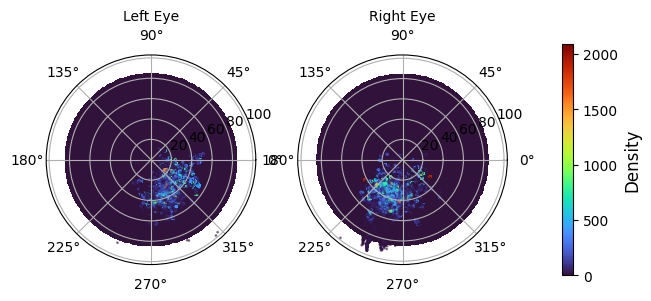

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime

def polar_density_scatter_plot_both_eyes(phi_left, theta_left, phi_right, theta_right, nbins=200, cmap='viridis', export_path=None):
    """
    Creates a combined polar plot with two subplots (one for each eye) that shows:
      - A density heatmap computed by binning the data in polar coordinates.
      - An overlaid scatter plot of the individual data points colored by the local density.
      
    The angular data (in degrees) are assumed to be:
      - k_phi: azimuth (in degrees)
      - k_theta: elevation (in degrees)
      
    Conversion to polar coordinates is done as:
      - r = sqrt(k_phi^2 + k_theta^2)
      - θₚ = arctan2(k_theta, k_phi)
      
    Parameters:
      - phi_left, theta_left: 1D arrays for the left eye.
      - phi_right, theta_right: 1D arrays for the right eye.
      - nbins: Number of bins for both the angular and radial dimensions (default 200).
      - cmap: Colormap name (e.g., 'viridis' or 'turbo').
      - export_path: If provided (as a string path), the function will export the figure.
    """
    
    def plot_single_polar_density(ax, phi_data, theta_data, nbins, cmap):
        # Ensure data are numpy arrays and remove any pairs with NaNs.
        phi_data = np.array(phi_data)
        theta_data = np.array(theta_data)
        mask = ~np.isnan(phi_data) & ~np.isnan(theta_data)
        phi_data = phi_data[mask]
        theta_data = theta_data[mask]
        
        # Convert to polar coordinates.
        r = np.sqrt(phi_data**2 + theta_data**2)
        theta_p = np.arctan2(theta_data, phi_data)  # θₚ in radians
        
        # Define bins:
        # For the angular coordinate, span -π to π.
        angle_bins = np.linspace(-np.pi, np.pi, nbins+1)
        # For r, use a maximum that covers our range; for angles from -60 to 60, max r ≈ sqrt(60²+60²)
        r_max = np.sqrt(60**2 + 60**2)
        r_bins = np.linspace(0, r_max, nbins+1)
        
        # Compute a 2D histogram in (angle, r) space.
        density, angle_edges, r_edges = np.histogram2d(theta_p, r, bins=[angle_bins, r_bins])
        density = density.T  # Now shape is (len(r_bins)-1, len(angle_bins)-1)
        
        # Create a meshgrid for plotting.
        Angle, R = np.meshgrid(angle_edges, r_edges)
        
        # Plot the heatmap.
        hm = ax.pcolormesh(Angle, R, density, cmap=cmap)
        
        # For the scatter, assign each point its density from the histogram.
        angle_idx = np.digitize(theta_p, angle_bins) - 1
        r_idx = np.digitize(r, r_bins) - 1
        # Clip indices to ensure they are in range.
        angle_idx = np.clip(angle_idx, 0, nbins-1)
        r_idx = np.clip(r_idx, 0, nbins-1)
        point_density = density[r_idx, angle_idx]
        
        # Overlay the scatter plot.
        sc = ax.scatter(theta_p, r, c=point_density, cmap=cmap, s=1, alpha=0.5)
        
        return hm, sc

    # Create a figure with two polar subplots side by side.
    fig, axes = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(7, 3))
    
    hm_left, sc_left = plot_single_polar_density(axes[0], phi_left, theta_left, nbins, cmap)
    axes[0].set_title("Left Eye", fontsize=10)
    
    hm_right, sc_right = plot_single_polar_density(axes[1], phi_right, theta_right, nbins, cmap)
    axes[1].set_title("Right Eye", fontsize=10)
    
    #fig.suptitle("Combined Polar Density Scatter Plot", fontsize=16)
    
    # Add a colorbar common to both subplots.
    # We use the heatmap from the left subplot as the mappable.
    cbar = fig.colorbar(hm_left, ax=axes, orientation='vertical', fraction=0.05, pad=0.1)
    cbar.set_label('Density', fontsize=12)
    
    # If export_path is provided, export the figure.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"polar_density_scatter_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "polar_density_scatter_both_eyes.pdf")
        png_file = os.path.join(full_export_path, "polar_density_scatter_both_eyes.png")
        fig.savefig(pdf_file, format="pdf", bbox_inches="tight", dpi=300)
        fig.savefig(png_file, format="png", bbox_inches="tight", dpi=300)
        print(f"Exported plot to: {full_export_path}")
    
    plt.show()


animal = "PV_126"
phi_left, theta_left = aggregate_eye_angles(block_dict, animal=animal, eye='L')
phi_right, theta_right = aggregate_eye_angles(block_dict, animal=animal, eye='R')


export_directory = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\scatter_heatmap_combo"  
polar_density_scatter_plot_both_eyes(phi_left, theta_left, phi_right, theta_right, nbins=200, cmap='turbo', export_path=export_directory)


3420


<ipython-input-63-210f51f7bf16>:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


synced = 1710


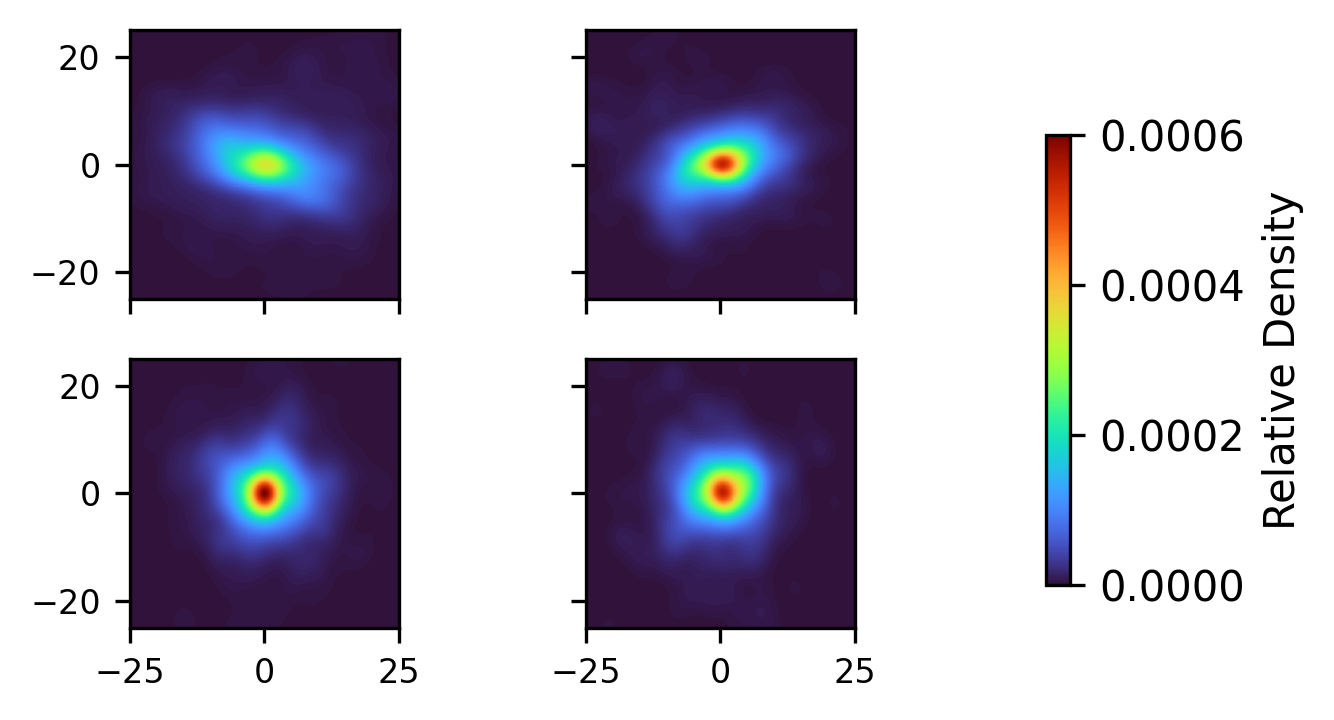

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
import datetime
import pickle

def plot_saccade_heatmaps_comparison_angle(synced_saccades, non_synced_saccades, export_path=None, nbins=200,
                                           global_min=-1.5, global_max=1.5, cmap=plt.cm.turbo, figsize=(4, 2.5)):
    """
    Plots a stacked 2D KDE heatmap for synced (top) and non-synced saccades using angle data.
    Instead of the calibrated pupil displacements (calib_dx, calib_dy), it uses the angle columns:
      - delta_phi (horizontal angle in degrees, plotted on the x-axis)
      - delta_theta (vertical angle in degrees, plotted on the y-axis)
    
    The heatmaps are normalized (integral = 1) and a consistent colorbar scale is used across both conditions.
    
    Parameters:
      - synced_saccades: DataFrame with saccade data for the synced condition.
      - non_synced_saccades: DataFrame with saccade data for the non-synced condition.
      - export_path: Path to export the plot and data (optional).
      - nbins: Number of bins for KDE evaluation.
      - global_min, global_max: Axis limits for KDE evaluation.
      - cmap: Colormap for the heatmap.
      - figsize: Figure size tuple.
    """
    # Extract data using the angle columns: note the inverted order.
    def extract_eye_data(df, eye):
        # Now, x-axis = delta_phi and y-axis = delta_theta.
        return df.query('eye == @eye')[['delta_phi', 'delta_theta']].dropna().values.T
    
    # For synced saccades
    r_phi_s, r_theta_s = extract_eye_data(synced_saccades, "R")
    l_phi_s, l_theta_s = extract_eye_data(synced_saccades, "L")
    # For non-synced saccades
    r_phi_ns, r_theta_ns = extract_eye_data(non_synced_saccades, "R")
    l_phi_ns, l_theta_ns = extract_eye_data(non_synced_saccades, "L")
    
    # Function to evaluate KDE with integral normalization
    def evaluate_kde(x, y):
        k = gaussian_kde(np.array([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j, global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)  # Normalize so the sum equals 1
        return zi
    
    # Compute KDEs for each eye and condition
    zi_r_s = evaluate_kde(r_phi_s, r_theta_s)
    zi_l_s = evaluate_kde(l_phi_s, l_theta_s)
    zi_r_ns = evaluate_kde(r_phi_ns, r_theta_ns)
    zi_l_ns = evaluate_kde(l_phi_ns, l_theta_ns)
    
    # Determine a consistent color scale across all heatmaps
    vmin = min(zi_r_s.min(), zi_l_s.min(), zi_r_ns.min(), zi_l_ns.min())
    vmax = max(zi_r_s.max(), zi_l_s.max(), zi_r_ns.max(), zi_l_ns.max())
    
    # Create figure with 2 rows and 2 columns of subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)
    
    # Helper function to plot an individual heatmap
    def plot_heatmap(ax, zi, title):
        im = ax.imshow(zi.T, extent=[global_min, global_max, global_min, global_max],
                       origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        #ax.set_title(title, fontsize=10)
        #ax.set_xlabel('delta_phi [deg]', fontsize=8)
        #ax.set_ylabel('delta_theta [deg]', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im
    
    im1 = plot_heatmap(axes[0, 0], zi_r_s, 'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], zi_l_s, 'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], zi_l_ns, 'Left (Non-Synced)')
    
    # Add a colorbar to the right side of the figure
    cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    cb = plt.colorbar(im1, cax=cax)
    cb.set_label('Relative Density', fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    print(f'synced = {len(r_phi_s)}')
    # Handle export if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_angle_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_angle.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_collections_angle.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({'synced': synced_saccades, 'non_synced': non_synced_saccades}, f)
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()

# Example usage:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material')
synced_saccades = synced_saccade_collection.query('animal == "PV_126"')
non_synced_saccades = non_synced_saccade_collection.query('animal == "PV_126"')
print(len(synced_saccades))
plot_saccade_heatmaps_comparison_angle(synced_saccades, non_synced_saccades, export_path=None, nbins=200,
                                       global_min=-25, global_max=25, cmap=plt.cm.turbo, figsize=(4, 2.5))


Exported plot to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\overall_displacement_angle_histogram_2025_03_05_07_01_59


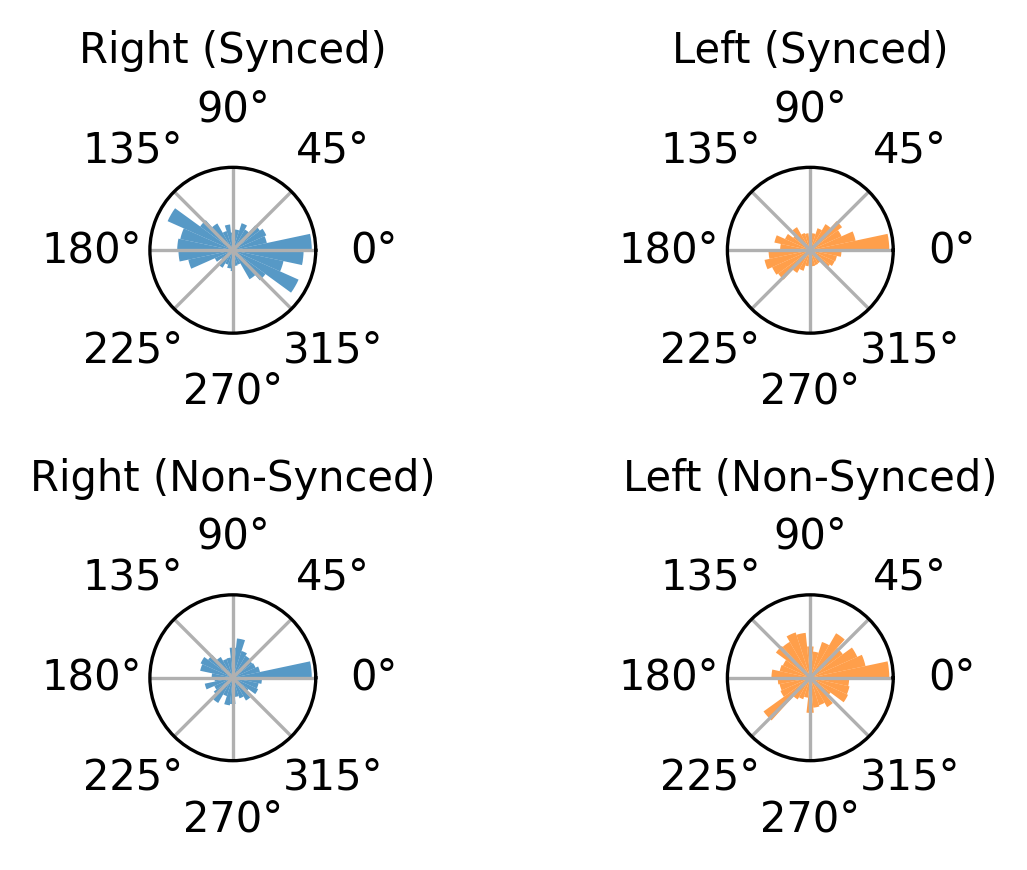

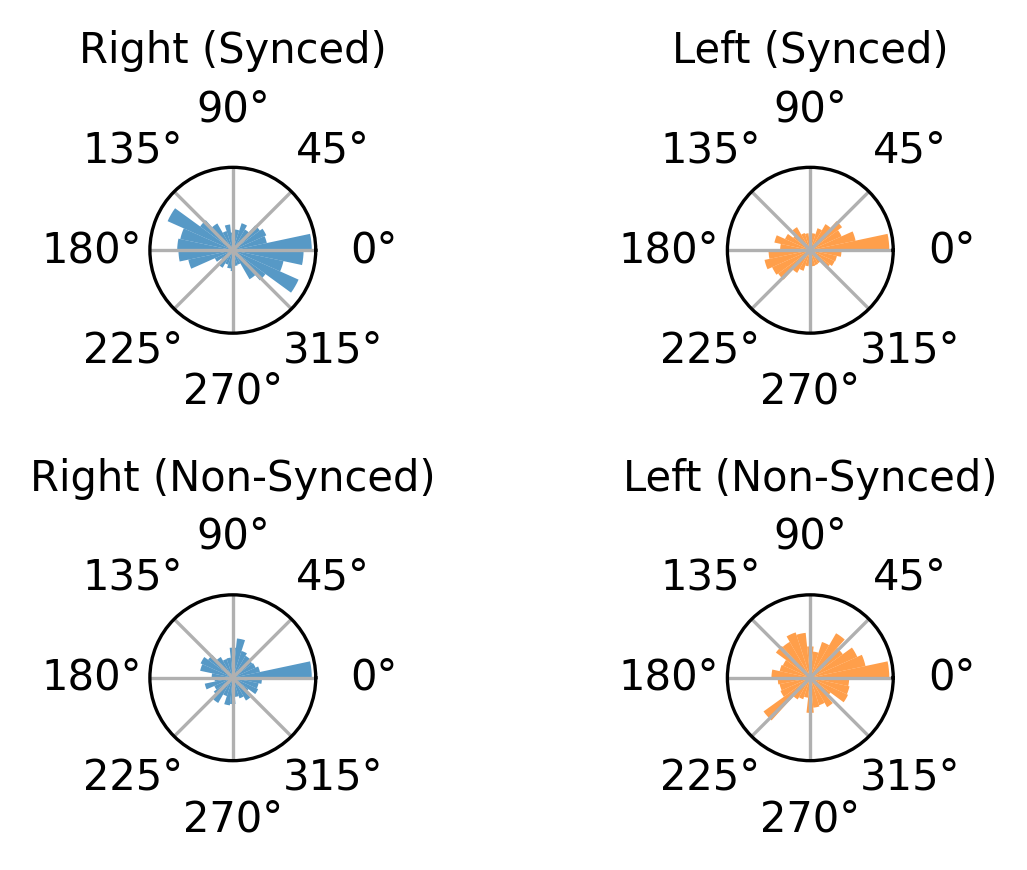

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import pickle

def plot_overall_displacement_angle_histogram(synced_saccades, non_synced_saccades, export_path=None, bins=30, figsize=(4, 3)):
    """
    Computes the overall displacement angle for each saccade event from the 'delta_phi' and 'delta_theta'
    columns, and plots polar histograms for both synced and non-synced saccades (separately for Right and Left eyes).
    
    The overall displacement angle is computed as:
        overall_direction = arctan2(delta_theta, delta_phi) mod 2π
        
    Parameters:
      - synced_saccades (pd.DataFrame): Saccade events for the synchronized condition, must include 
            'delta_phi' and 'delta_theta' and an 'eye' column.
      - non_synced_saccades (pd.DataFrame): Saccade events for the non-synchronized condition,
            with the same required columns.
      - export_path (str or pathlib.Path, optional): Directory to save the plot.
      - bins (int): Number of bins for the histogram.
      - figsize (tuple): Figure size (width, height).
    """
    def extract_overall_angle(df, eye):
        # Filter for the given eye
        sub = df.query('eye == @eye')
        # Ensure the columns are numeric
        delta_phi = pd.to_numeric(sub['delta_phi'], errors='coerce').to_numpy(dtype=float)
        delta_theta = pd.to_numeric(sub['delta_theta'], errors='coerce').to_numpy(dtype=float)
        # Remove NaN values
        valid = ~np.isnan(delta_phi) & ~np.isnan(delta_theta)
        delta_phi = delta_phi[valid]
        delta_theta = delta_theta[valid]
        # Compute overall angle in radians, wrapped to [0, 2*pi)
        overall_angle = np.arctan2(delta_theta, delta_phi) % (2 * np.pi)
        return overall_angle

    # Extract overall angles for each condition and eye
    overall_right_synced = extract_overall_angle(synced_saccades, "R")
    overall_left_synced  = extract_overall_angle(synced_saccades, "L")
    overall_right_ns     = extract_overall_angle(non_synced_saccades, "R")
    overall_left_ns      = extract_overall_angle(non_synced_saccades, "L")
    
    # Create a 2x2 grid of polar subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': 'polar'}, figsize=figsize, dpi=300)
    
    # Plot a polar histogram for each group
    axes[0, 0].hist(overall_right_synced, bins=bins, color='C0', alpha=0.75)
    axes[0, 0].set_title('Right (Synced)', fontsize=10)
    
    axes[0, 1].hist(overall_left_synced, bins=bins, color='C1', alpha=0.75)
    axes[0, 1].set_title('Left (Synced)', fontsize=10)
    
    axes[1, 0].hist(overall_right_ns, bins=bins, color='C0', alpha=0.75)
    axes[1, 0].set_title('Right (Non-Synced)', fontsize=10)
    
    axes[1, 1].hist(overall_left_ns, bins=bins, color='C1', alpha=0.75)
    axes[1, 1].set_title('Left (Non-Synced)', fontsize=10)
    
    # Optionally remove radial ticks for a cleaner look
    for ax in axes.flatten():
        ax.set_rticks([])
        ax.grid(True)
    
    plt.tight_layout()
    
    # Handle export if an export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(str(export_path), f"overall_displacement_angle_histogram_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "overall_displacement_angle_histogram.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {full_export_path}")
    
    plt.show()
    return fig

# Example usage:
# export_path = r'path/to/export_directory'
plot_overall_displacement_angle_histogram(synced_saccades, non_synced_saccades, export_path=None, bins=30, figsize=(4,3))


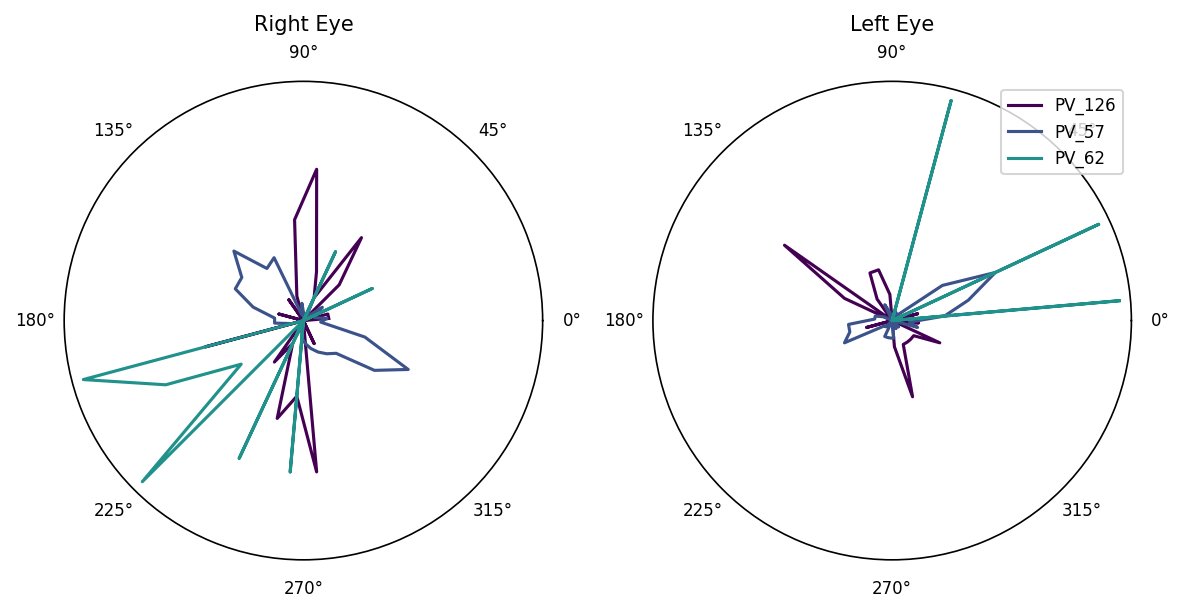

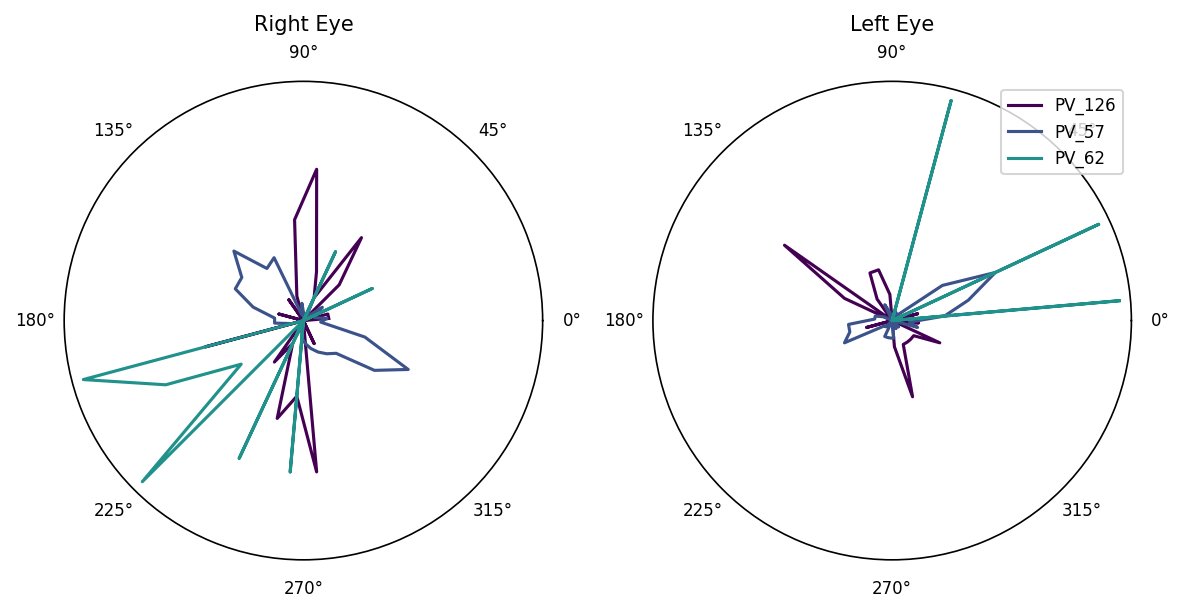

In [68]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal_angle(saccade_collection, num_bins=36, figure_size=(8,4), export_path=None):
    """
    Computes the overall displacement angle for each saccade event using the new angle-based delta values,
    and then creates a multi-animal polar histogram line plot for each eye.
    
    The overall displacement angle (in degrees) is computed as:
    
        overall_angle_deg = (arctan2(delta_theta, delta_phi) * (180/π)) mod 360
    
    This function groups the saccade events by animal and then—for each animal and for each eye (Right and Left)
    computes a normalized histogram (density) of these overall angles. The histogram is then delineated as a line
    on a polar plot. The plots for the Right and Left eyes are placed side-by-side.
    
    Parameters:
      - saccade_collection (pd.DataFrame): DataFrame containing saccade events with at least the following columns:
            'delta_phi', 'delta_theta', 'animal', and 'eye'.
      - num_bins (int): Number of bins for the histogram (default is 36).
      - figure_size (tuple): Figure size (width, height).
      - export_path (str or pathlib.Path, optional): Directory path to export the plot and data.
    
    Returns:
      - fig: The matplotlib figure.
    """
    # Get unique animals in the dataset
    animals = np.unique(saccade_collection['animal'])
    
    # Create two polar subplots: one for Right Eye, one for Left Eye
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw={'projection': 'polar'})
    
    # Use a colormap to assign a unique color to each animal.
    colors = plt.cm.viridis(np.linspace(0, 0.5, len(animals)))
    
    # For each animal, process both eyes.
    for color, animal in zip(colors, animals):
        # Filter saccade events for the current animal.
        animal_data = saccade_collection[saccade_collection['animal'] == animal]
        
        # Define a helper to compute overall displacement angles:
        def compute_overall_angles(df):
            # Ensure numeric conversion
            delta_phi = pd.to_numeric(df['delta_phi'], errors='coerce').to_numpy(dtype=float)
            delta_theta = pd.to_numeric(df['delta_theta'], errors='coerce').to_numpy(dtype=float)
            valid = ~np.isnan(delta_phi) & ~np.isnan(delta_theta)
            if valid.sum() == 0:
                return np.array([])
            # Compute overall angle in radians then convert to degrees and wrap to [0,360)
            overall_rad = np.arctan2(delta_theta[valid], delta_phi[valid])
            overall_deg = np.degrees(overall_rad) % 360
            return overall_deg
        
        # Process Right Eye:
        data_right = animal_data[animal_data['eye'] == "R"]
        overall_right = compute_overall_angles(data_right)
        if overall_right.size > 0:
            # Compute histogram (density normalized)
            hist_r, bin_edges_r = np.histogram(overall_right, bins=num_bins, range=(0,360), density=True)
            # Compute bin centers
            bin_centers_r = (bin_edges_r[:-1] + bin_edges_r[1:]) / 2
            # Close the circle by appending the first bin at the end
            bin_centers_r = np.append(bin_centers_r, bin_centers_r[0])
            hist_r = np.append(hist_r, hist_r[0])
            # Plot on the right-eye subplot (axs[0])
            axs[0].plot(np.deg2rad(bin_centers_r), hist_r, label=str(animal), color=color, linewidth=1.5)
        
        # Process Left Eye:
        data_left = animal_data[animal_data['eye'] == "L"]
        overall_left = compute_overall_angles(data_left)
        if overall_left.size > 0:
            hist_l, bin_edges_l = np.histogram(overall_left, bins=num_bins, range=(0,360), density=True)
            bin_centers_l = (bin_edges_l[:-1] + bin_edges_l[1:]) / 2
            bin_centers_l = np.append(bin_centers_l, bin_centers_l[0])
            hist_l = np.append(hist_l, hist_l[0])
            # Plot on the left-eye subplot (axs[1])
            axs[1].plot(np.deg2rad(bin_centers_l), hist_l, label=str(animal), color=color, linewidth=1.5)
    
    # Format each subplot: remove radial tick labels and grid for clarity
    for ax, title in zip(axs, ['Right Eye', 'Left Eye']):
        ax.set_title(title, fontsize=10)
        ax.set_rticks([])  # remove radial ticks
        ax.grid(False)
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    # Add a legend only on the left subplot (or as desired)
    axs[1].legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    
    # Export if an export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(str(export_path), f"polar_histogram_multianimal_angle_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "polar_histogram_multianimal_angle.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_collection_angle.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")
    
    plt.show()
    return fig

create_saccade_polar_histogram_multianimal_angle(all_saccade_collection.query('length > 4'), num_bins=36, figure_size=(8,4), export_path=None)

In [314]:
all_saccade_collection['angle_r2'] = all_saccade_collection['delta_theta']**2 + all_saccade_collection['delta_phi']**2
synced_saccade_collection['angle_r2'] = synced_saccade_collection['delta_theta']**2 + synced_saccade_collection['delta_phi']**2
non_synced_saccade_collection['angle_r2'] = non_synced_saccade_collection['delta_theta']**2 + non_synced_saccade_collection['delta_phi']**2


In [293]:
all_saccade_collection.query('length == 1 and angle_r2 > 0 and angle_r2 < 0.1').head()

Main Sub saccade_start_ind saccade_end_ind saccade_start_timestamp  \
64    64.0   L             18055           18056             6.73866e+06   
91    91.0   L             23257           23258             8.50558e+06   
129  129.0   L             44202           44203             1.56208e+07   
201  201.0   L             69181           69182             2.41063e+07   
237  237.0   L             86814           86815             3.00968e+07   

    saccade_end_timestamp saccade_on_ms saccade_off_ms length  \
64              6.739e+06        336933         336950      1   
91            8.50592e+06        425279         425296      1   
129           1.56211e+07        781038         781055      1   
201           2.41066e+07   1.20531e+06    1.20533e+06      1   
237           3.00971e+07   1.50484e+06    1.50486e+06      1   

    magnitude_raw_pixel  ... phi_end_pos delta_theta  delta_phi overall_disp  \
64              10.8573  ...     55.5438   -0.155104    0.10569      0.18769   
91              6.49962  ...     54.4185   -0.217154  0.0939521     0.236607   
129             17.8724  ...     12.6482    0.123329  -0.119234     0.171543   
201             5.90432  ...     62.4569   0.0364602   0.177466     0.181173   
237             5.37471  ...     62.6136    0.296492  0.0660084     0.303751   

    head_movement eye block animal time_to_peak_v   angle_r2  
64          False   L   023  PV_62              0  0.0352276  
91          False   L   023  PV_62              0  0.0559827  
129         False   L   023  PV_62              0  0.0294269  
201         False   L   023  PV_62              0  0.0328235  
237         False   L   023  PV_62              0  0.0922645  

[5 rows x 31 columns]

In [228]:
len(all_saccade_collection.query('angle_r2 > 0'))

12326

In [ ]:
len(all_saccade_collection)
len(synced_saccade_collection)

c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\numpy\core\_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


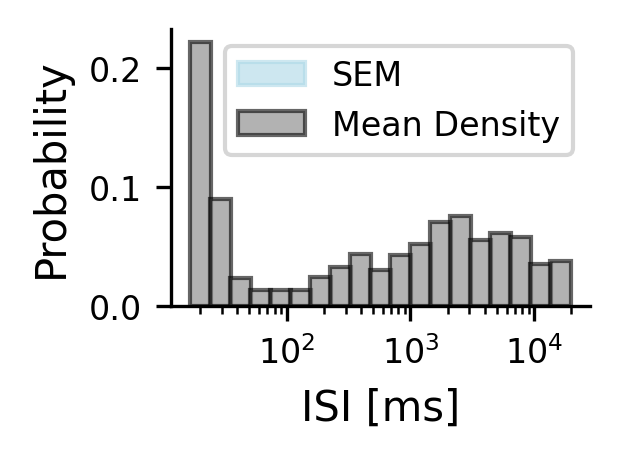

In [50]:
def export_inter_saccade_intervals_density_average_with_shaded_sem(
    all_saccade_collection, figure_size=(6, 4), export_path=None, plot_name='ISI_histogram'
):
    """
    Plots an average density histogram of inter-saccade intervals with shaded SEM across animals.

    Parameters:
    - all_saccade_collection (pd.DataFrame): DataFrame with saccade data
    - figure_size (tuple): Size of the plot
    - export_path (str): Directory for export (optional)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    import pickle
    import datetime
    from scipy.stats import sem

    # Sort and calculate inter-saccade intervals
    all_saccade_collection_sorted = all_saccade_collection.sort_values(
        by=["animal", "block", "saccade_on_ms"]
    )
    grouped = all_saccade_collection_sorted.groupby("animal")
    bins = np.geomspace(17, 20000, 20)

    animal_densities = []

    # Compute density histograms for each animal
    for animal, group in grouped:
        inter_saccade_intervals = []
        for block, block_group in group.groupby("block"):
            saccade_times = block_group["saccade_on_ms"].values
            if len(saccade_times) > 1:
                inter_saccade_intervals.extend(np.diff(saccade_times))

        # Compute density histogram
        hist, _ = np.histogram(inter_saccade_intervals, bins=bins)
        hist = hist / np.sum(hist)
        animal_densities.append(hist)

    # Convert to NumPy array for averaging
    animal_densities = np.array(animal_densities)

    # Compute mean and SEM
    mean_density = animal_densities.mean(axis=0)
    sem_density = sem(animal_densities, axis=0, nan_policy="omit")

    # Calculate the shaded limits
    lower_bound = mean_density - sem_density
    upper_bound = mean_density + sem_density

    # Plot histogram with shaded SEM
    bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Geometric mean for log bins
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    ax.bar(
        bin_centers,
        mean_density,
        width=np.diff(bins),
        align="center",
        color="gray",
        edgecolor="black",
        alpha=0.6,
        label="Mean Density",
    )

    # Add shaded SEM
    ax.fill_between(
        bin_centers,
        lower_bound,
        upper_bound,
        color="lightblue",
        alpha=0.6,
        label="SEM",
    )

    # Customize plot
    ax.set_xscale("log")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    #ax.set_title("Average Density Histogram of Inter-Saccade Intervals", fontsize=12)
    ax.set_xlabel("ISI [ms]", fontsize=10)
    ax.set_ylabel("Probability", fontsize=10)
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.legend(fontsize=8, loc="upper right")
    plt.grid(False)

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"inter_saccade_export_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, plot_name)
        fig.savefig(pdf_file, format="pdf", bbox_inches="tight", dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "all_saccade_collection.pkl")
        with open(data_file, "wb") as f:
            pickle.dump(all_saccade_collection, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
export_inter_saccade_intervals_density_average_with_shaded_sem(all_saccade_collection.query('animal=="PV_62"'), figure_size=(1.8, 1.2), export_path=None, plot_name='ISI_histogram_multi_animal.pdf')

[1.20000000e+01 1.77317759e+01 2.62013229e+01 3.87163321e+01
 5.72091102e+01 8.45349266e+01 1.24912864e+02 1.84577243e+02
 2.72740191e+02 4.03013995e+02 5.95512819e+02 8.79958318e+02
 1.30026864e+03 1.92133934e+03 2.83906321e+03 4.19513604e+03
 6.19893432e+03 9.15984283e+03 1.35350233e+04 2.00000000e+04]


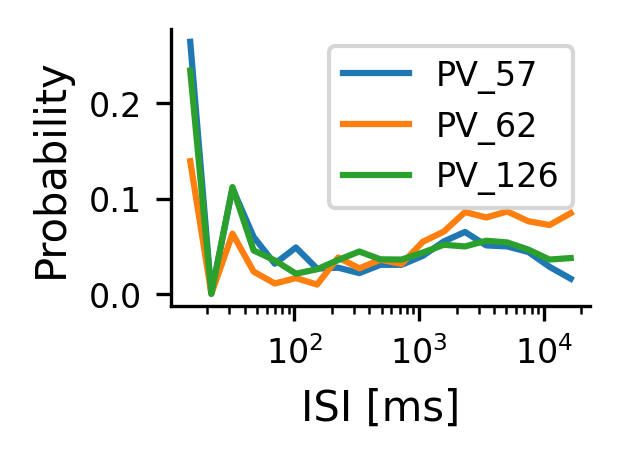

In [71]:
def export_inter_saccade_intervals_density_traces(
    animal_dataframes, figure_size=(6, 4), export_path=None, plot_name='ISI_histogram.pdf'
):
    """
    Plots density histogram traces of inter-saccade intervals for each animal.

    Parameters:
    - animal_dataframes (list of pd.DataFrame): List of DataFrames, each containing saccade data for one animal.
    - figure_size (tuple): Size of the plot.
    - export_path (str): Directory for export (optional).
    - plot_name (str): File name for the exported plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    import pickle
    import datetime

    # Define bins using a logarithmic (geometric) spacing
    
    def generate_log_mult17_bins(num_bins, low=16, high=20000):
        # Define k domain: ISI = 17 * k
        k_min = 1
        k_max = high // low  # integer division
        # We need num_bins+1 edges
        k_edges = np.geomspace(k_min, k_max, num_bins+1)
        # Round to the nearest integer and multiply by 17
        bins = np.unique(np.round(k_edges).astype(int) * low)
        return bins

    # Example usage:
    num_bins = 20
    #bins = generate_log_mult17_bins(num_bins)
    
    bins = np.geomspace(12, 20000, 20)
    
    bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Geometric mean for log bins
    print(bins)
    # Setup color mapping
    num_animals = len(animal_dataframes)
    cmap = plt.get_cmap('tab10')  # you can change this to another colormap if desired
    colors = [cmap(i) for i in range(num_animals)]

    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Loop through each animal DataFrame
    for idx, df in enumerate(animal_dataframes):
        # Get animal identifier (if present) or use a default name
        animal_name = df['animal'].iloc[0] if 'animal' in df.columns else f"Animal {idx+1}"
        
        inter_saccade_intervals = []
        # Assuming each DataFrame can have multiple blocks
        for block, block_group in df.groupby("block"):
            saccade_times = block_group["saccade_on_ms"].values
            diffs = np.diff(saccade_times)
 # Just show first 20 unique values
            if len(saccade_times) > 1:
                diffs = np.diff(saccade_times)
                inter_saccade_intervals.extend(diffs[diffs >= 15])
        if not inter_saccade_intervals:
            continue

        
        # Compute histogram density

        hist, _ = np.histogram(inter_saccade_intervals, bins=bins)
        total = np.nansum(hist)
        hist_density = hist / total if total > 0 else hist
        
        # Plot each animal's histogram as a trace (line plot) with no markers and line width of 1
        ax.plot(bin_centers, hist_density, color=colors[idx], label=str(animal_name), linewidth=1.5)

    # Customize the plot
    ax.set_xscale("log")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_xlabel("ISI [ms]", fontsize=10)
    ax.set_ylabel("Probability", fontsize=10)
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.legend(fontsize=8, loc="upper right")
    plt.grid(False)

    # Optionally export the figure and data
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"inter_saccade_export_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save the plot
        pdf_file = os.path.join(full_export_path, plot_name)
        fig.savefig(pdf_file, format="pdf", bbox_inches="tight", dpi=300)

        # Save the list of DataFrames
        data_file = os.path.join(full_export_path, "animal_dataframes.pkl")
        with open(data_file, "wb") as f:
            pickle.dump(animal_dataframes, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


animal_dataframes = [
    all_saccade_collection.query('animal=="PV_57" and length > 0'),
    all_saccade_collection.query('animal=="PV_62" and length > 0'),
    all_saccade_collection.query('animal=="PV_126" and length > 0')
]

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_4\material\Inter_saccade_intervals_histogram'
export_inter_saccade_intervals_density_traces(
    animal_dataframes, figure_size=(1.8, 1.2), export_path=None, plot_name='ISI_histogram.pdf')

In [39]:
import numpy as np

def generate_log_mult17_bins(num_bins, low=17, high=20000):
    # Define k domain: ISI = 17 * k
    k_min = 1
    k_max = high // low  # integer division
    # We need num_bins+1 edges
    k_edges = np.geomspace(k_min, k_max, num_bins+1)
    # Round to the nearest integer and multiply by 17
    bins = np.unique(np.round(k_edges).astype(int) * low)
    return bins

# Example usage:
num_bins = 20
bins = generate_log_mult17_bins(num_bins)
print("Bin edges:", bins)


Bin edges: [   17    34    51    68   102   136   204   289   408   578   833  1190
  1683  2397  3417  4862  6919  9860 14042 19992]


In [40]:
# monocular saccade graph: 
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle


def process_profile(profile, expected_length):
    """
    Adjusts a profile to the expected length by either padding or snipping.
    """
    current_length = len(profile)

    if current_length == expected_length:
        return profile

    # Snip or pad to match the expected length
    if current_length > expected_length:
        excess = (current_length - expected_length) // 2
        return profile[excess:excess + expected_length]
    else:
        pad_before = (expected_length - current_length) // 2
        pad_after = expected_length - current_length - pad_before
        return np.pad(profile, (pad_before, pad_after), constant_values=np.nan)


def average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=200, sampling_rate=60,
                            export_path=None):
    half_window = window_ms // 2
    expected_length = int((window_ms / 1000) * sampling_rate)
    time_axis = (np.arange(expected_length) * 1000 / sampling_rate) - half_window

    saccade_profiles = []
    opposite_eye_profiles = []

    for _, row in non_synced_saccade_collection.iterrows():
        block_num = row['block']
        eye = row['eye']
        start_ts = row['saccade_on_ms']
        opposite_eye = 'L' if eye == 'R' else 'R'

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]
        current_eye_data = block.left_eye_data if eye == 'L' else block.right_eye_data
        opposite_eye_data = block.left_eye_data if opposite_eye == 'L' else block.right_eye_data

        saccade_profile = current_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
        opposite_profile = opposite_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values

        if len(saccade_profile) == 0 or len(opposite_profile) == 0:
            print(f"Skipped saccade at {start_ts} due to missing data.")
            continue

        # Ensure fixed length through padding or snipping
        saccade_profiles.append(process_profile(saccade_profile, expected_length))
        opposite_eye_profiles.append(process_profile(opposite_profile, expected_length))

    if not saccade_profiles or not opposite_eye_profiles:
        print("No valid saccade profiles found.")
        return None, None

    avg_saccade = np.nanmean(np.vstack(saccade_profiles), axis=0)
    avg_opposite_eye = np.nanmean(np.vstack(opposite_eye_profiles), axis=0)

    # Plot the results
    fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', which='major', length=5, color='black')
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_ylabel("Speed (pixels/ms)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.plot(time_axis, avg_saccade, label="Monocular Saccade", color='g')
    ax.plot(time_axis, avg_opposite_eye, label="Opposite Eye", color='b')
    ax.set_title("Average Saccade Profiles")
    ax.set_xlabel("Time (ms)")
    ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)
    plt.show()

    # Save results
    if export_path:
        t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f"Saccade_Profile_{t}"
        os.makedirs(export_dir, exist_ok=True)

        pdf_path = export_dir / "average_saccade_profiles.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')

        data_dict = {
            'time_axis': time_axis,
            'avg_saccade': avg_saccade,
            'avg_opposite_eye': avg_opposite_eye,
            'saccade_collection': non_synced_saccade_collection
        }
        pickle_path = export_dir / "saccade_profiles.pkl"
        with open(pickle_path, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Data saved to {export_dir}")

    return saccade_profiles, opposite_eye_profiles




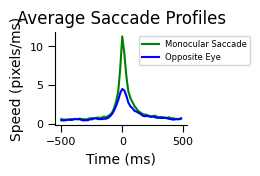

In [41]:
no_head_mov_saccades = non_synced_saccade_collection.query('head_movement == False')
export_path = pathlib.Path(
    r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\Monocular_saccade_averages_no_head_mov')
saccade_profiles = average_saccade_profile(no_head_mov_saccades, block_dict, window_ms=1000, sampling_rate=60,
                                           export_path=export_path)

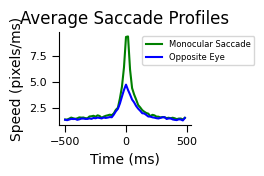

Data saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\Monocular_saccade_averages\Saccade_Profile_2025_02_27_22_31


In [43]:

export_path = pathlib.Path(
    r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\Monocular_saccade_averages')
saccade_profiles = average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=1000, sampling_rate=60,
                                           export_path=export_path)


In [49]:
all_saccade_collection.columns

Index(['Main', 'Sub', 'saccade_start_ind', 'saccade_end_ind',
       'saccade_start_timestamp', 'saccade_end_timestamp', 'saccade_on_ms',
       'saccade_off_ms', 'length', 'magnitude_raw_pixel', 'magnitude_pixel',
       'overall_angle_pixel', 'magnitude_raw_angular', 'overall_angle_deg',
       'speed_profile_pixel', 'speed_profile_pixel_calib',
       'speed_profile_angular', 'diameter_profile', 'theta_init_pos',
       'theta_end_pos', 'phi_init_pos', 'phi_end_pos', 'delta_theta',
       'delta_phi', 'overall_disp', 'head_movement', 'eye', 'block', 'animal',
       'time_to_peak_v'],
      dtype='object')

18985it [00:38, 492.81it/s]


18084 18084
Scatter plot saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_03_11_17_28\faster_vs_slower_scatter.pdf


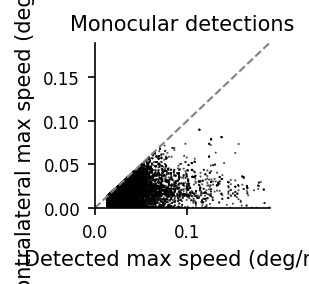

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib

def plot_faster_vs_slower_final(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=1.5):
    """
    Plots a scatter plot where the x-axis always represents the larger velocity (either detected or contralateral),
    and the y-axis represents the smaller velocity.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot. Defaults to None.
        iqr_multiplier (float): Multiplier for interquartile range (IQR) in outlier detection. Defaults to 1.5.
    """
    faster_speeds = []
    slower_speeds = []

    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        block_num = row['block']
        start_ts = row['saccade_on_ms']
        detected_speed_profile = row['speed_profile_angular']  # Velocity profile for the detected eye
        block_key = f"{row['animal']}_block_{block_num}"

        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye data
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds
        max_detected = np.nanmax(detected_speed_profile / 17) if len(detected_speed_profile) > 0 else np.nan
        max_contralateral = np.nanmax(contralateral_eye_speed_profile.values / 17) \
            if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan
        
        # Assign faster and slower speeds
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            faster_speeds.append(max(max_detected, max_contralateral))
            slower_speeds.append(min(max_detected, max_contralateral))

    # Convert to NumPy arrays
    faster_speeds = np.array(faster_speeds) / 17
    slower_speeds = np.array(slower_speeds) / 17
    print(len(faster_speeds), len(slower_speeds))

    # Outlier removal using the IQR method
    all_speeds = np.concatenate([faster_speeds, slower_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = (faster_speeds >= lower_bound) & (faster_speeds <= upper_bound) & \
                    (slower_speeds >= lower_bound) & (slower_speeds <= upper_bound)

    faster_speeds = faster_speeds[valid_indices]
    slower_speeds = slower_speeds[valid_indices]

    # Determine axis limits
    min_value = min(np.min(faster_speeds), np.min(slower_speeds))
    max_value = max(np.max(faster_speeds), np.max(slower_speeds))

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    ax.scatter(faster_speeds, slower_speeds, alpha=0.7, s=1, c='k', edgecolors='none')

    # Plot diagonal reference line
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Configure plot appearance
    ax.set_title("Monocular detections", fontsize=10)
    ax.set_xlabel("Detected max speed (deg/ms)", fontsize=10)
    ax.set_ylabel("Contralateral max speed (deg/ms)", fontsize=10)
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()

    # Save the plot if export_path is provided
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        pdf_path = export_dir / "faster_vs_slower_scatter.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Scatter plot saved to {pdf_path}")

    plt.show()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
# Example usage
plot_faster_vs_slower_final(all_saccade_collection, block_dict, export_path=export_path, iqr_multiplier=10)


8230it [00:16, 489.25it/s]


8230 8230
Scatter plot saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_03_12_20_50\right_vs_left_scatter.pdf
Data saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_03_12_20_50


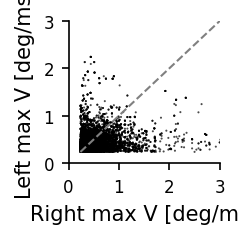

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import tqdm  # Make sure tqdm is imported if you use it

def plot_right_vs_left_eye(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=1.5):
    """
    Plots a scatter plot where the x-axis represents the right eye's max speed and the y-axis represents the left eye's max speed.
    
    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot. Defaults to None.
        iqr_multiplier (float): Multiplier for interquartile range (IQR) in outlier detection. Defaults to 1.5.
    """
    right_eye_speeds = []
    left_eye_speeds = []

    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        block_num = row['block']
        start_ts = row['saccade_on_ms']
        detected_speed_profile = row['speed_profile_angular']  # Velocity profile for the detected eye
        block_key = f"{row['animal']}_block_{block_num}"

        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye data
        if row['eye'] == 'L':
            # Detected eye is left; so get right eye data as contralateral.
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @start_ts - 34 and ms_axis <= @start_ts + 100'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            # Detected eye is right; so get left eye data as contralateral.
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @start_ts - 34 and ms_axis <= @start_ts + 100'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (dividing by 17 as in the original function)
        max_detected = np.nanmax(detected_speed_profile / 17) if len(detected_speed_profile) > 0 else np.nan
        max_contralateral = np.nanmax(contralateral_eye_speed_profile.values / 17) \
            if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan
        
        # Only add if both values are valid
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                # Detected is left eye, so:
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                # Detected is right eye, so:
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert to NumPy arrays
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print(len(right_eye_speeds), len(left_eye_speeds))

    # Outlier removal using the IQR method (based on combined speeds)
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = (right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) & \
                    (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound)

    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Determine axis limits
    min_value = min(np.min(right_eye_speeds), np.min(left_eye_speeds))
    max_value = max(np.max(right_eye_speeds), np.max(left_eye_speeds))

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(1.7, 1.7), dpi=150)
    ax.scatter(right_eye_speeds, left_eye_speeds, alpha=0.7, s=1, c='k', edgecolors='none')

    # Plot diagonal reference line for comparison
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Configure plot appearance
    #ax.set_title("Eye speed comparison", fontsize=10)
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)

    plt.tight_layout()

    # Save the plot if export_path is provided
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        pdf_path = export_dir / "right_vs_left_scatter.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Scatter plot saved to {pdf_path}")
        data_dict = {
            'saccade_collection': all_saccade_collection
        }
        pickle_path = export_dir / "saccade_collection.pkl"
    
        with open(pickle_path, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Data saved to {export_dir}")
    plt.show()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}' 

plot_right_vs_left_eye(synced_saccade_collection, block_dict, export_path=export_path, iqr_multiplier=10)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pearson correlation coefficient: 0.808
P-value: 0.000e+00


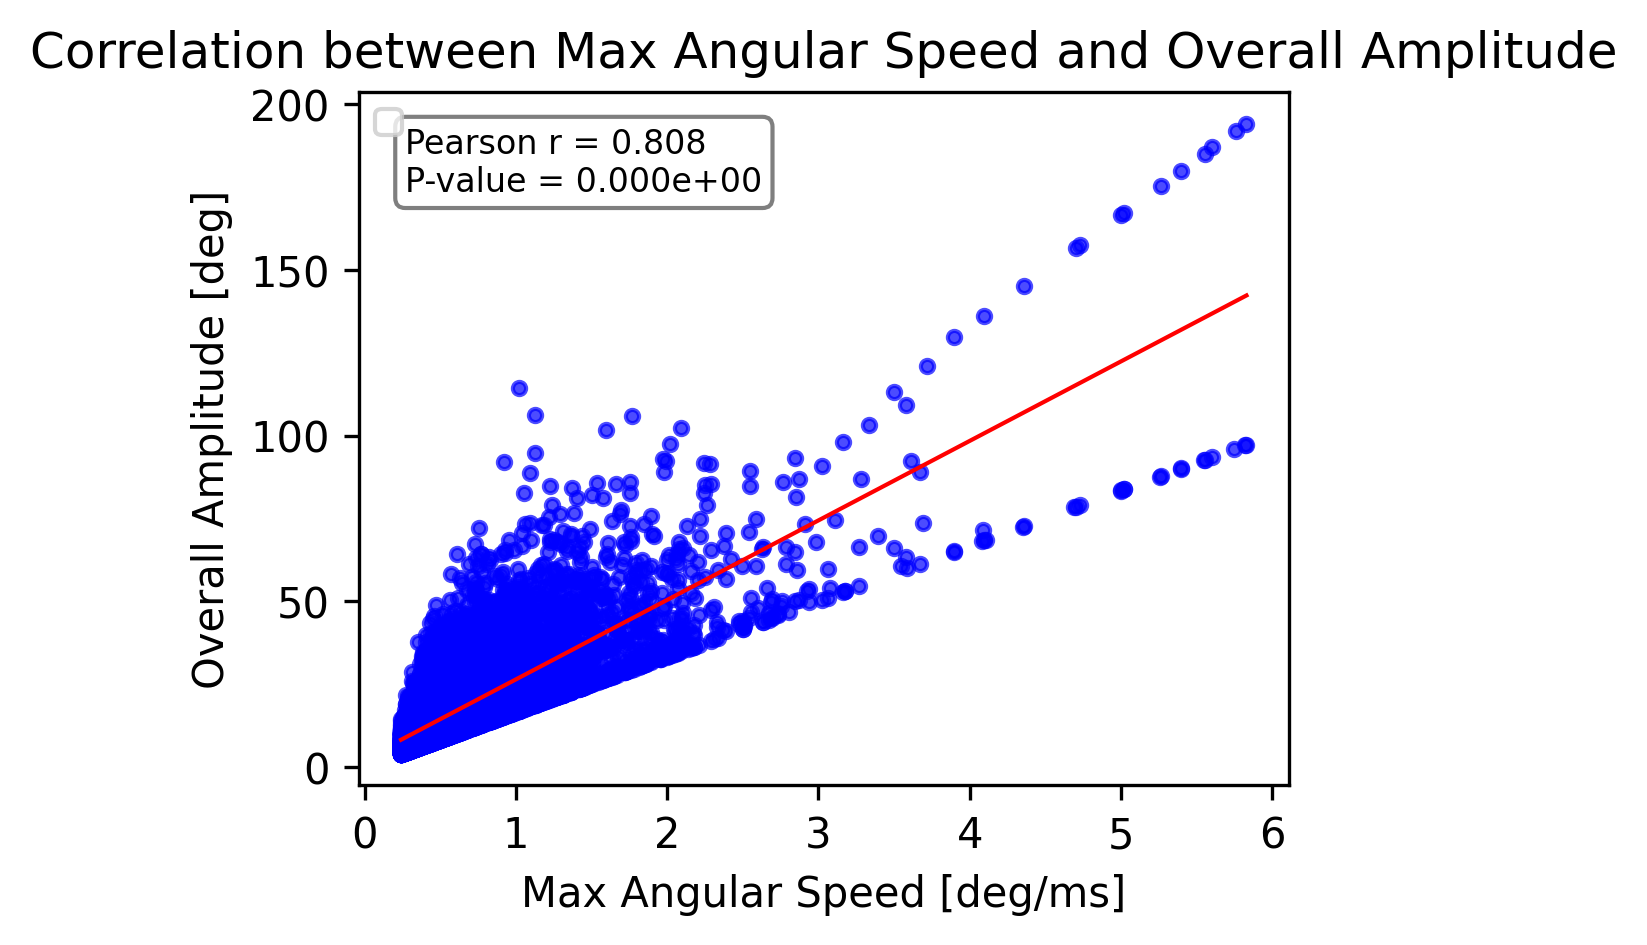

In [48]:
def plot_correlation_max_speed_vs_amplitude(
    saccade_collection, sampling_rate=60, export_path=None, fig_size=(4,3)
):
    """
    Plots the correlation between the maximal angular speed and the overall amplitude of saccades.
    
    For each saccade (row in the dataframe), the function computes the maximal value of the 
    'speed_profile_angular' array (converted from deg/frame to deg/ms using the provided sampling_rate)
    and compares it to the 'magnitude_raw_angular' value.
    
    A scatter plot is generated with a fitted regression line. The Pearson correlation coefficient 
    and its p-value are printed and also shown on the plot.
    
    Parameters:
      - saccade_collection: DataFrame containing at least the columns 'speed_profile_angular' (an array)
                            and 'magnitude_raw_angular'.
      - sampling_rate: Sampling rate in Hz (default 60 Hz) used to convert speeds from deg/frame to deg/ms.
      - export_path: Optional directory path to export the plot and data.
      - fig_size: Tuple specifying the size (width, height) of the figure.
    """
    import os
    import datetime
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import pearsonr

    # Compute frame duration (ms per frame)
    frame_duration = 1000 / sampling_rate

    max_speeds = []
    amplitudes = []

    # Iterate over rows to compute maximum speed and corresponding amplitude
    for idx, row in saccade_collection.iterrows():
        profile = row['speed_profile_angular']
        amplitude = row['magnitude_raw_angular']
        # Check for missing data or empty profiles
        if profile is None or len(profile) == 0 or np.isnan(amplitude):
            continue
        # Convert profile to numpy array and convert to deg/ms
        profile = np.array(profile)
        # Compute maximum, ignoring any NaN values
        max_speed = np.nanmax(profile / frame_duration)
        max_speeds.append(max_speed)
        amplitudes.append(amplitude)

    max_speeds = np.array(max_speeds)
    amplitudes = np.array(amplitudes)

    if len(max_speeds) == 0:
        print("No valid saccade entries to compute correlation.")
        return

    # Compute Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_speeds, amplitudes)

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    ax.scatter(max_speeds, amplitudes, s=10, color='blue', alpha=0.7)

    # Compute and plot the regression line
    slope, intercept = np.polyfit(max_speeds, amplitudes, 1)
    x_vals = np.linspace(max_speeds.min(), max_speeds.max(), 100)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color='red', lw=1)

    # Label the plot
    ax.set_xlabel('Max Angular Speed [deg/ms]', fontsize=10)
    ax.set_ylabel('Overall Amplitude [deg]', fontsize=10)
    ax.set_title('Correlation between Max Angular Speed and Overall Amplitude', fontsize=12)
    ax.legend(fontsize=8)

    # Display correlation stats on the plot
    textstr = f'Pearson r = {corr_coef:.3f}\nP-value = {p_value:.3e}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    print(f"Pearson correlation coefficient: {corr_coef:.3f}")
    print(f"P-value: {p_value:.3e}")

    # Optionally export the plot and saccade data
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"max_speed_vs_amplitude_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "max_speed_vs_amplitude.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\correlation_plots'
plot_correlation_max_speed_vs_amplitude(
    saccade_collection, sampling_rate=60, export_path=None, fig_size=(4,3)
)

In [45]:
synced_saccade_collection.columns

Index(['Main', 'Sub', 'saccade_start_ind', 'saccade_end_ind',
       'saccade_start_timestamp', 'saccade_end_timestamp', 'saccade_on_ms',
       'saccade_off_ms', 'length', 'magnitude_raw_pixel', 'magnitude_pixel',
       'overall_angle_pixel', 'magnitude_raw_angular', 'overall_angle_deg',
       'speed_profile_pixel', 'speed_profile_pixel_calib',
       'speed_profile_angular', 'diameter_profile', 'theta_init_pos',
       'theta_end_pos', 'phi_init_pos', 'phi_end_pos', 'delta_theta',
       'delta_phi', 'head_movement', 'eye', 'block', 'animal',
       'time_to_peak_v'],
      dtype='object')

In [ ]:


def plot_max_speeds_scatter(all_saccade_collection, block_dict, export_path=None,iqr_multiplier=1.5):
    """
    Plots a scatter plot of maximum speeds of the left eye vs the right eye for all saccades.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing all saccade data.
        block_dict (dict): Dictionary containing block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot. Defaults to None.
    """
    left_eye_max_speeds = []
    right_eye_max_speeds = []

    for _, row in all_saccade_collection.iterrows():
        block_num = row['block']
        start_ts = row['saccade_on_ms']

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get speed data for the left and right eyes
        left_eye_data = block.left_eye_data.query(
            'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['speed_r'].values / 17
        right_eye_data = block.right_eye_data.query(
            'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['speed_r'].values / 17

        if len(left_eye_data) == 0 or len(right_eye_data) == 0:
            continue
        # Append maximum speeds only if valid data is available
        if not np.all(np.isnan(left_eye_data)):
            left_eye_max_speeds.append(np.nanmax(left_eye_data))
        else:
            left_eye_max_speeds.append(0)  # Or any other default value, like np.nan
        
        if not np.all(np.isnan(right_eye_data)):
            right_eye_max_speeds.append(np.nanmax(right_eye_data))
        else:
            right_eye_max_speeds.append(0)  # Or any other default value, like np.nan

    # Convert to NumPy arrays for easier filtering
    left_eye_max_speeds = np.array(left_eye_max_speeds)
    right_eye_max_speeds = np.array(right_eye_max_speeds)

    # Outlier removal using the IQR method
    all_speeds = np.concatenate([left_eye_max_speeds, right_eye_max_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Filter points within bounds
    valid_indices = (left_eye_max_speeds >= lower_bound) & (left_eye_max_speeds <= upper_bound) & \
                    (right_eye_max_speeds >= lower_bound) & (right_eye_max_speeds <= upper_bound)

    left_eye_max_speeds = left_eye_max_speeds[valid_indices]
    right_eye_max_speeds = right_eye_max_speeds[valid_indices]

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    ax.scatter(left_eye_max_speeds, right_eye_max_speeds, alpha=0.7, s=2, c='k', edgecolors='none')

    # Plot diagonal reference line
    max_val = max(max(left_eye_max_speeds, default=0), max(right_eye_max_speeds, default=0))
    ax.plot([0, max_val], [0, max_val], linestyle='--', color='gray', linewidth=1)

    # Configure plot appearance
    ax.set_title("saccade max speed correlation", fontsize=10)
    ax.set_xlabel("Max Speed (Left Eye, pix/ms)", fontsize=10)
    ax.set_ylabel("Max Speed (Right Eye, pix/ms)", fontsize=10)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)

    plt.tight_layout()

    # Save the plot if export_path is provided
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        pdf_path = export_dir / "max_speeds_scatter.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Scatter plot saved to {pdf_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\temporary_drafts\saccade_speed_correlation_all'
plot_max_speeds_scatter(all_saccade_collection, block_dict, iqr_multiplier=4, export_path=None)

In [41]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection, figure_size=(8, 4), export_path=None):
    # Extract unique animals
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    # Set up the polar plots
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 0.5, len(animals)))  # Unique colors for each animal

    # Iterate through each animal
    for color, animal in zip(colors, animals):
        # Filter saccades for the current animal
        animal_saccades = saccade_collection.query('animal == @animal')

        # Process right eye
        saccade_angles_r = animal_saccades.query('eye == "R"')['overall_angle_deg']
        hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360), density=True)
        bin_centers_r = list((bin_edges_r[:-1] + bin_edges_r[1:]) / 2)
        # Close the circular plot
        bin_centers_r.append(bin_centers_r[0])
        hist_r = np.append(hist_r, hist_r[0])
        axs[0].plot(
            np.deg2rad(bin_centers_r), hist_r,
            label=f'{animal} saccades)',
            color=color
        )

        # Process left eye
        saccade_angles_l = animal_saccades.query('eye == "L"')['overall_angle_deg']
        hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360), density=True)
        bin_centers_l = list((bin_edges_l[:-1] + bin_edges_l[1:]) / 2)
        # Close the circular plot
        bin_centers_l.append(bin_centers_l[0])
        hist_l = np.append(hist_l, hist_l[0])
        axs[1].plot(
            np.deg2rad(bin_centers_l), hist_l,
            label=f'{animal}',
            color=color
        )

    # Add shaded areas for probability = 0.1
    for ax in axs:
        theta = np.linspace(0, 2 * np.pi, 500)
        ax.fill_between(theta, 0, 0.005, color='gray', alpha=0.2, zorder=0, label='0.005 Prob.')
        
    # Format plots
    for ax, title in zip(axs, ['Right Eye', 'Left Eye']):
        if title == 'Left Eye':
            ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=6)
        else:
            ax.legend().remove()  # Remove legend for the right eye plot
        ax.grid(False)
        ax.set_yticks([])
        # Set font size for polar tick markers
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()

    # Save the figure if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_MultiAnimal_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)
        
        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")
        
        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.tight_layout()
    plt.show()


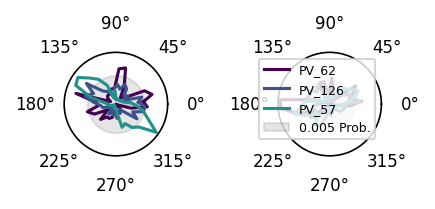

In [45]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(all_saccade_collection.query('length > 2 and magnitude_raw_angular > 4 '), (3,2),export_path=None)

In [83]:
all_saccade_collection.head()

Main Sub saccade_start_ind saccade_end_ind saccade_start_timestamp  \
0   0.0   L               390             392                  737587   
1   1.0   L               551             553                  792288   
2   2.0   L              4198            4200              2.0314e+06   
3   3.0   L              4338            4340             2.07896e+06   
4   4.0   L              4401            4403             2.10036e+06   

  saccade_end_timestamp saccade_on_ms saccade_off_ms length  \
0                738266       36879.3        36913.3      2   
1                792967       39614.4        39648.3      2   
2           2.03208e+06        101570         101604      2   
3           2.07964e+06        103948         103982      2   
4           2.10104e+06        105018         105052      2   

  magnitude_raw_pixel  ... theta_end_pos phi_init_pos phi_end_pos delta_theta  \
0             46.5781  ...      -38.9527      2.17538     9.09644     2.77577   
1             40.3534  ...      -35.0874      11.3902     17.8945     6.72474   
2             42.4259  ...      -43.3495       13.872     5.16257    -4.27756   
3              34.947  ...      -49.2517      3.44181    -4.23696    -2.56718   
4              28.982  ...       -53.343      3.87879    0.724884    -7.27041   

  delta_phi head_movement eye block animal time_to_peak_v  
0   6.92106         False   L   023  PV_62             17  
1   6.50435          True   L   023  PV_62             17  
2  -8.70941          True   L   023  PV_62             17  
3  -7.67877         False   L   023  PV_62             17  
4   -3.1539         False   L   023  PV_62             17  

[5 rows x 29 columns]

In [62]:
all_saccade_collection.iloc[0]

Main                                                                         0
Sub                                                                          L
saccade_start_ind                                                          390
saccade_end_ind                                                            392
saccade_start_timestamp                                                 737587
saccade_end_timestamp                                                   738266
saccade_on_ms                                                          36879.3
saccade_off_ms                                                         36913.3
length                                                                       2
magnitude_raw_pixel                                                    46.5781
magnitude_pixel                                                        2.18917
overall_angle_pixel                                                    20.2618
magnitude_raw_angular                               

(array([3089., 1818., 1970., 2167., 2404., 2076., 1675., 1707., 1814.,
        2220.]),
 array([  0.        ,  35.99861002,  71.99722004, 107.99583006,
        143.99444008, 179.9930501 , 215.99166013, 251.99027015,
        287.98888017, 323.98749019, 359.98610021]),
 <BarContainer object of 10 artists>)

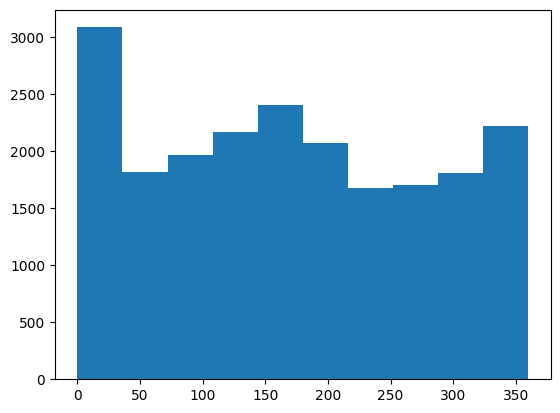

In [24]:
plt.hist(all_saccade_collection.overall_angle_deg)

(3, 39)


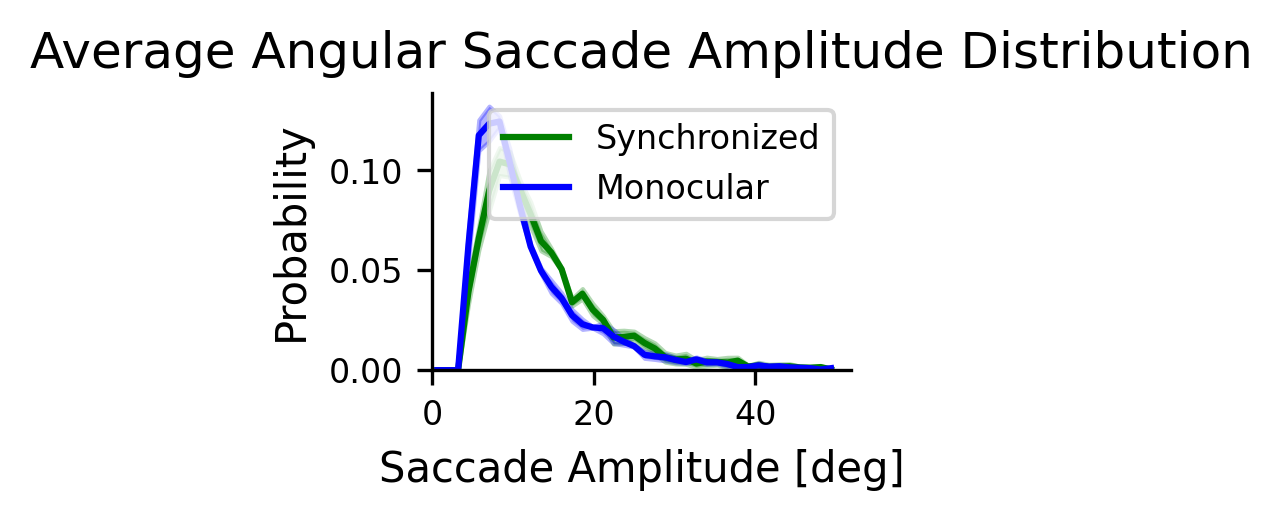

In [33]:
# overall saccade magnitude histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
import datetime
import os
import pickle

def plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2.5, 1.7), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the average angular saccade amplitude likelihood histogram across animals,
    showing only the outline (with SEM shading) of the distributions.
    
    For each saccade event, the angular amplitude is computed as:
    
        angular_amplitude [deg] = sqrt( (angle_dx)^2 + (angle_dy)^2 )
    
    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synced saccade data with an 'animal' column,
          and the angular delta columns 'angle_dx' and 'angle_dy'.
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synced saccade data with an 'animal' column,
          and the angular delta columns.
    - figure_size (tuple): Size of the figure for the plot.
    - export_path (str or pathlib.Path, optional): Path to save the plot and data.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    # Compute angular amplitude for each event (if not already computed)
    # We'll add a new column "angular_magnitude" computed from angle_dx and angle_dy.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])
    
    bin_centers = (bins[:-1] + bins[1:]) / 2  # For plotting the outline
    
    # Group by animals
    animals = synced_saccade_collection['animal'].unique()
    num_animals = len(animals)
    
    # Store normalized histograms for synced and non-synced data
    synced_likelihoods = []
    non_synced_likelihoods = []
    
    for animal in animals:
        # For each animal, filter the angular amplitudes
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        
        # Calculate histograms normalized to probabilities
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()
        
        synced_likelihoods.append(synced_hist)
        non_synced_likelihoods.append(non_synced_hist)
    
    # Convert to arrays for averaging
    synced_likelihoods = np.array(synced_likelihoods)
    non_synced_likelihoods = np.array(non_synced_likelihoods)
    print(np.shape(synced_likelihoods))
    
    # Calculate mean and SEM across animals
    synced_mean = synced_likelihoods.mean(axis=0)
    synced_sem = synced_likelihoods.std(axis=0) / np.sqrt(num_animals)
    
    non_synced_mean = non_synced_likelihoods.mean(axis=0)
    non_synced_sem = non_synced_likelihoods.std(axis=0) / np.sqrt(num_animals)
    
    # Plot averaged histograms
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    
    # Plot outline and SEM for synced (angle-based)
    ax.plot(bin_centers, synced_mean, color='green', linestyle='-', linewidth=1.5, label='Synchronized')
    ax.fill_between(bin_centers, synced_mean - synced_sem, synced_mean + synced_sem, color='green', alpha=0.3)
    
    # Plot outline and SEM for non-synced (angle-based)
    ax.plot(bin_centers, non_synced_mean, color='blue', linestyle='-', linewidth=1.5, label='Monocular')
    ax.fill_between(bin_centers, non_synced_mean - non_synced_sem, non_synced_mean + non_synced_sem, color='blue', alpha=0.3)
    
    # Customize the plot
    ax.set_title('Average Angular Saccade Amplitude Distribution', fontsize=12)
    ax.set_xlabel('Saccade Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_averaged_histogram_angle_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_averaged_histogram_angle.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "averaged_saccade_amplitude_angle_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced_mean': synced_mean,
                'synced_sem': synced_sem,
                'non_synced_mean': non_synced_mean,
                'non_synced_sem': non_synced_sem,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")
    
    
    plt.show()
    print()
    
export_path = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg"

plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(1.7, 1.2), export_path=None,
    bins=np.linspace(0,50,40))

In [55]:
synced_saccade_collection.columns

Index(['Main', 'Sub', 'saccade_start_ind', 'saccade_end_ind',
       'saccade_start_timestamp', 'saccade_end_timestamp', 'saccade_on_ms',
       'saccade_off_ms', 'length', 'magnitude_raw_pixel', 'magnitude_pixel',
       'overall_angle_pixel', 'magnitude_raw_angular', 'overall_angle_deg',
       'speed_profile_pixel', 'speed_profile_pixel_calib',
       'speed_profile_angular', 'diameter_profile', 'theta_init_pos',
       'theta_end_pos', 'phi_init_pos', 'phi_end_pos', 'delta_theta',
       'delta_phi', 'overall_disp', 'head_movement', 'eye', 'block', 'animal',
       'time_to_peak_v'],
      dtype='object')

c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\matplotlib\axes\_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\matplotlib\axes\_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


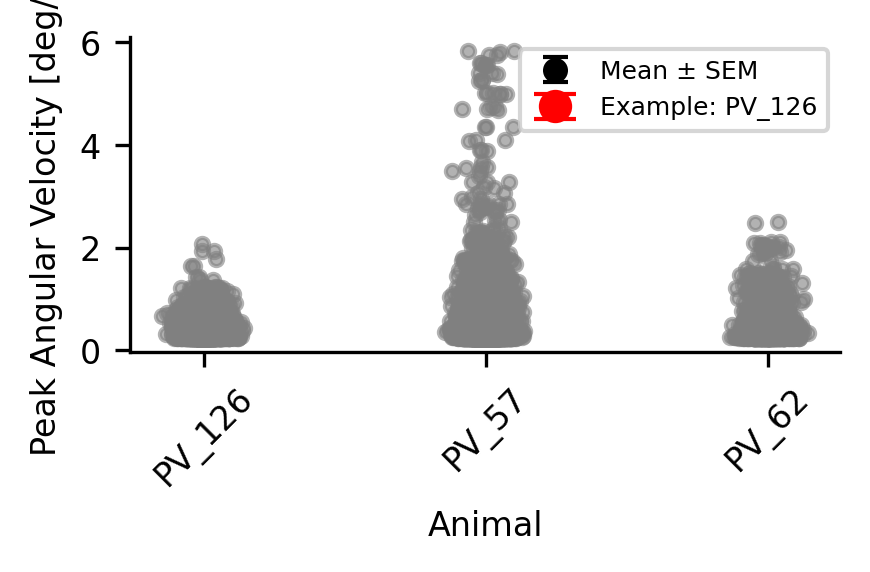

In [49]:
def plot_peak_velocity_scatter(
    saccade_collection, sampling_rate=60, example_animal=None,
    export_path=None, fig_size=(3,2), set_ylim=None
):
    """
    Creates a scatter plot of peak angular velocities (converted from deg/frame to deg/ms)
    for each animal in the saccade collection.
    
    For each animal, it:
      - Computes the peak velocity from each speed profile in 'speed_profile_angular'
      - Converts the value from deg/frame to deg/ms using the provided sampling_rate
      - Computes the mean peak velocity and its standard error (SEM)
    
    The function then plots:
      - All individual peak values as semi-transparent grey dots (with slight x-axis jitter)
      - The mean peak velocity for each animal with vertical error bars (SEM)
      - Optionally highlights a provided example animal in red.
    
    Parameters:
      - saccade_collection: DataFrame with at least the following columns:
          'animal' and 'speed_profile_angular' (a list/array of angular speed values in deg/frame)
      - sampling_rate: Sampling rate in Hz (default 60 Hz).
      - example_animal: Optional string specifying an animal to highlight.
      - export_path: Optional directory path to export the plot as a PDF.
      - fig_size: Tuple defining the figure size.
      - set_ylim: Optional y-axis limits.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime, os

    # Calculate frame duration in ms (used to convert deg/frame to deg/ms)
    frame_duration = 1000 / sampling_rate
    
    # Get sorted unique animal names
    animals = sorted(saccade_collection['animal'].dropna().unique())
    
    # Prepare dictionaries to store peak values, means and SEMs for each animal
    all_peak_values = {}
    peak_means = []
    peak_stderr = []
    
    # Loop over each animal
    for animal in animals:
        # Get the group's data
        group = saccade_collection[saccade_collection['animal'] == animal]
        peaks = []
        
        # Iterate over each row (saccade) in the group
        for _, row in group.iterrows():
            profile = row['speed_profile_angular']
            # Skip if the profile is missing or empty
            if profile is None or (hasattr(profile, '__len__') and len(profile) == 0):
                continue
            # Ensure the profile is a NumPy array
            profile = np.array(profile)
            # Compute the peak velocity in deg/ms: max(angular speed) / (ms/frame)
            peak = np.max(profile) / frame_duration
            peaks.append(peak)
        
        # Compute mean and standard error if any peaks were found
        if len(peaks) > 0:
            mean_peak = np.mean(peaks)
            std_peak = np.std(peaks)
            stderr_peak = std_peak / np.sqrt(len(peaks))
        else:
            mean_peak = np.nan
            stderr_peak = np.nan
        
        all_peak_values[animal] = peaks
        peak_means.append(mean_peak)
        peak_stderr.append(stderr_peak)
    
    # Create the scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    x_positions = np.arange(len(animals))
    
    # Plot individual peak velocity values with a slight horizontal jitter for clarity.
    for i, animal in enumerate(animals):
        points = all_peak_values[animal]
        if len(points) > 0:
            # Add small jitter to spread points out
            jitter = np.random.normal(0, 0.04, size=len(points))
            ax.scatter(np.full(len(points), x_positions[i]) + jitter, points,
                       color='grey', alpha=0.6, s=10)
    
    # Plot mean peak velocity with SEM error bars
    ax.errorbar(x_positions, peak_means, yerr=peak_stderr, fmt='o',
                color='black', capsize=3, markersize=5, label='Mean ± SEM')
    
    # Optionally highlight the example animal in a different color
    if example_animal is not None and example_animal in animals:
        idx = animals.index(example_animal)
        ax.errorbar(x_positions[idx], peak_means[idx], yerr=peak_stderr[idx],
                    fmt='o', color='red', capsize=5, markersize=7, label=f'Example: {example_animal}')
    
    ax.set_xticks(x_positions)
    ax.set_xticklabels(animals, rotation=45, fontsize=8)
    ax.set_xlabel('Animal', fontsize=8)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=8)
    if set_ylim is not None:
        ax.set_ylim(set_ylim)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=6)
    plt.tight_layout()
    
    # Export the plot if an export path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"peak_velocity_scatter_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "peak_velocity_scatter.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {full_export_path}")
    
    plt.show()

plot_peak_velocity_scatter(all_saccade_collection,sampling_rate=60,example_animal="PV_126",export_path=None,fig_size=(3,2))

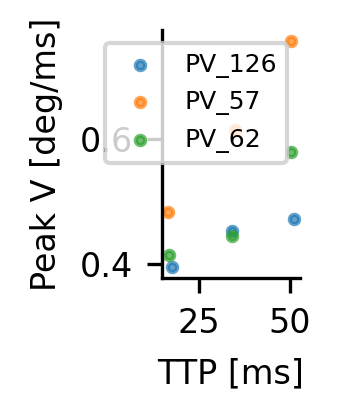

In [81]:
def plot_peak_velocity_vs_time(
    saccade_collection, sampling_rate=60, floor=None, ceiling=None, 
    export_path=None, fig_size=(2.5,1.7), set_xlim=None, example_animal=None, set_ylim=None
):
    """
    Computes and plots the peak angular velocity (in deg/ms) for each saccade,
    grouped by time-to-peak (in ms) and by animal.

    For each saccade:
      - The peak velocity is computed as the maximum value in 'speed_profile_angular'
        (which is in deg/frame) converted to deg/ms using the formula:
            peak_velocity = max(speed_profile_angular) * (sampling_rate / 1000)
      
    Then the data is grouped by 'time_to_peak_v' (already in ms) and 'animal', so that 
    each animal contributes one average peak velocity per time-to-peak value.

    The function creates a scatter plot where:
      - The x-axis is the time-to-peak (ms).
      - Each unique time value has as many points as the number of animals with data for that time.
      - A black error bar represents the mean ± SEM across animals for each time value.
      - Optionally, one animal can be highlighted in red.

    Parameters:
      - saccade_collection: DataFrame that must include:
            * 'time_to_peak_v': time-to-peak in ms.
            * 'speed_profile_angular': a list/array of angular speeds (in deg/frame).
            * 'animal': animal identifier.
      - sampling_rate: Sampling rate in Hz (default 60). Used to convert deg/frame to deg/ms.
      - floor: Minimum time-to-peak value (ms) to include.
      - ceiling: Maximum time-to-peak value (ms) to include.
      - export_path: Optional directory to export the plot as a PDF.
      - fig_size: Figure size tuple.
      - set_xlim: Optional x-axis limits.
      - example_animal: Optional string specifying an animal to highlight.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import datetime, os

    # Filter the dataframe for rows with valid time-to-peak and speed profile
    df = saccade_collection.dropna(subset=['time_to_peak_v', 'speed_profile_angular']).copy()
    
    # Apply floor and ceiling filters if provided (time-to-peak is in ms)
    if floor is not None:
        df = df[df['time_to_peak_v'] >= floor]
    if ceiling is not None:
        df = df[df['time_to_peak_v'] <= ceiling]
    
    # Compute the peak velocity for each saccade.
    # Convert from deg/frame to deg/ms by multiplying with (sampling_rate / 1000)
    def compute_peak(row):
        profile = np.array(row['speed_profile_angular'])
        return np.max(profile) * (sampling_rate / 1000)
    
    df['peak_velocity'] = df.apply(compute_peak, axis=1)
    
    # Group by time-to-peak and animal, so that each animal contributes one (average) peak value per time value.
    grouped = df.groupby(['time_to_peak_v', 'animal'])['peak_velocity'].mean().reset_index()
    
    # For each unique time-to-peak, compute the overall mean and SEM across animals.
    summary = grouped.groupby('time_to_peak_v').agg(
        mean_peak=('peak_velocity', 'mean'),
        sem_peak=('peak_velocity', lambda x: np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else 0)
    ).reset_index()
    
    # Create the scatter plot with x-axis in ms.
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    
    # Plot individual animal points (with slight jitter along the x-axis for clarity).
    for animal in grouped['animal'].unique():
        animal_data = grouped[grouped['animal'] == animal]
        jitter = np.random.normal(0, 0.5, size=len(animal_data))
        ax.scatter(animal_data['time_to_peak_v'] + jitter, animal_data['peak_velocity'], 
                   s=5, alpha=0.7, label=animal)
    
    # # Plot the overall mean ± SEM for each time-to-peak value.
    # ax.errorbar(summary['time_to_peak_v'], summary['mean_peak'], yerr=summary['sem_peak'], 
    #             fmt='o', color='black', capsize=3, markersize=5, label='Mean ± SEM')
    # 
    # Optionally, highlight a specific animal in red.
    if example_animal is not None:
        if example_animal in grouped['animal'].unique():
            animal_data = grouped[grouped['animal'] == example_animal]
            jitter = np.random.normal(0, 0.5, size=len(animal_data))
            ax.scatter(animal_data['time_to_peak_v'] + jitter, animal_data['peak_velocity'], 
                       s=5, color='red', alpha=0.9, label=f'Example: {example_animal}')
            
    ax.set_xlabel('TTP [ms]', fontsize=8)
    ax.set_ylabel('Peak V [deg/ms]', fontsize=8)
    if set_xlim is not None:
        ax.set_xlim(set_xlim)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if set_ylim is not None:
        ax.set_ylim(set_ylim)
    
    plt.tight_layout()
    ax.legend(fontsize=6)
    
    # Optionally export the plot as a PDF.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"peak_velocity_vs_time_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "peak_velocity_vs_time.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {full_export_path}")
    
    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles\inset'
plot_peak_velocity_vs_time(all_saccade_collection.query('time_to_peak_v > 0 and time_to_peak_v < 67'), sampling_rate=60, floor=1, ceiling=86, 
    export_path=None, fig_size=(1.2,1.5), set_xlim=None, example_animal=None)

Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\diff_per_animal\saccade_amplitude_difference_all_animals_2025_03_19_15_13_40


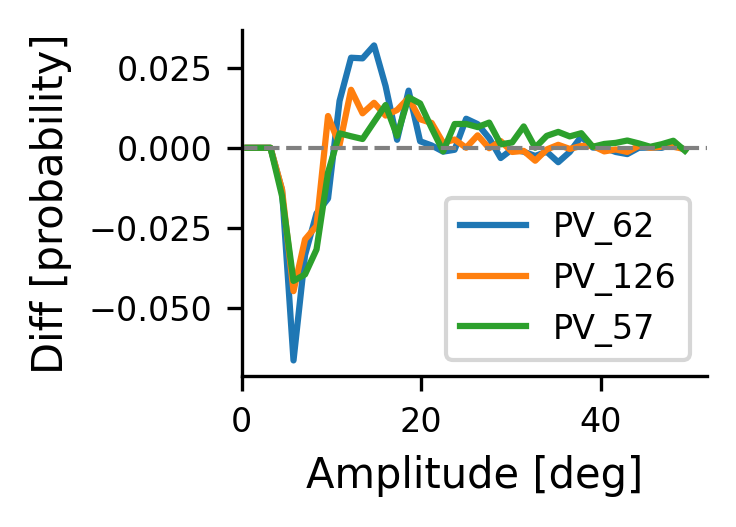

In [65]:
def plot_difference_saccade_amplitude_distribution_all_animals(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2.5, 1.7), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the difference (synchronized minus monocular) of the normalized saccade amplitude histograms
    for each animal on a single plot. Each animal's trace is given a unique color.
    
    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synchronized saccade data with an 'animal' column,
          and angular data (e.g. 'delta_phi' and 'delta_theta').
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synchronized saccade data with an 'animal' column.
    - figure_size (tuple): Size of the figure.
    - export_path (str or pathlib.Path, optional): Directory where the plot and data will be saved.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime, os, pickle

    # Make sure both DataFrames have the computed angular amplitude column.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])
    
    # Compute bin centers for plotting.
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Retrieve unique animals.
    animals = synced_saccade_collection['animal'].unique()

    # Set up a single figure and axes.
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Get the default color cycle from matplotlib.
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Loop over each animal and plot its difference trace.
    for i, animal in enumerate(animals):
        # Filter data for the current animal.
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Compute histograms.
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
        
        # Normalize the histograms.
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        # Compute the difference: (synchronized minus monocular).
        diff_trace = synced_hist - non_synced_hist

        # Plot the trace using a color from the cycle.
        ax.plot(bin_centers, diff_trace, color=colors[i % len(colors)], linestyle='-', 
                linewidth=1.5, label=f'{animal}')

    # Add a horizontal reference line at zero.
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Customize the plot.
    #ax.set_title('Difference in Saccade Amplitude Distribution\n(Synchronized - Monocular)', fontsize=12)
    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Diff [probability]', fontsize=10)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)

    # Optionally export the plot and data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_difference_all_animals_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals_data.pkl")
        # Save each animal's difference trace keyed by animal name.
        data_dict = {}
        for animal in animals:
            synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            synced_hist, _ = np.histogram(synced_data, bins=bins)
            non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
            if synced_hist.sum() > 0:
                synced_hist = synced_hist / synced_hist.sum()
            if non_synced_hist.sum() > 0:
                non_synced_hist = non_synced_hist / non_synced_hist.sum()
            data_dict[animal] = synced_hist - non_synced_hist
        with open(data_file, 'wb') as f:
            pickle.dump({
                'animal_diff_traces': data_dict,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\diff_per_animal'
plot_difference_saccade_amplitude_distribution_all_animals(synced_saccade_collection, 
                                                          non_synced_saccade_collection, 
                                                          figure_size=(2, 1.5), 
                                                          export_path=export_path,
                                                          bins=np.linspace(0,50,40))


In [59]:
np.linspace(0,50,40)

array([0.        , 0.12820513, 0.25641026, 0.38461538, 0.51282051,
       0.64102564, 0.76923077, 0.8974359 , 1.02564103, 1.15384615,
       1.28205128, 1.41025641, 1.53846154, 1.66666667, 1.79487179,
       1.92307692, 2.05128205, 2.17948718, 2.30769231, 2.43589744,
       2.56410256, 2.69230769, 2.82051282, 2.94871795, 3.07692308,
       3.20512821, 3.33333333, 3.46153846, 3.58974359, 3.71794872,
       3.84615385, 3.97435897, 4.1025641 , 4.23076923, 4.35897436,
       4.48717949, 4.61538462, 4.74358974, 4.87179487, 5.        ])